In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc
from functools import partial
import time
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition, h5_handling, math_functions, misc, plotting_helpers

%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%autoreload 2
import bmi_idap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline

In [6]:
params = {}
results = {}

In [7]:
results['general'] = {}

results['general']['datetime'] = str(datetime.datetime.now())
results['general']['cwd'] = os.getcwd()

In [8]:
params['paths'] = {}

# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/').resolve())
params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_0315N/20230404_day0/analysis_data/day0_analysis/').resolve())

## Directory with F.npy, stat.npy etc.
# params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve())
# params['paths']['dir_s2p']     = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve())
params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_0315N/20230404_day0/analysis_data/suite2p').resolve())

## Path of z-stack and z-position trace
params['paths']['path_zStack']    = str(Path('/media/rich/bigSSD/data_raw/BMI/mouse_0315N/20230404_day0/scanimage_data/zstack/zstack_00001_00001.tif'))
# params['paths']['path_zPosition'] = str(Path('/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/z_positions.h5'))


## Path of iscell. Can be from neural net output (iscell_NN)
params['paths']['path_iscell'] = str(Path(params['paths']['dir_analysisFiles']) / 'iscell_NN_tqm.npy')

## Path of tqm (trace quality metrics). Used to get dFoF parameters
params['paths']['path_tqm'] = str(Path(params['paths']['dir_analysisFiles']) / 'trace_quality.pkl')


params['paths']['dir_save']       =  copy.copy(params['paths']['dir_analysisFiles'])
params['paths']['path_save_weights'] = str(Path(params['paths']['dir_save']) / 'weights_day0')
params['paths']['path_save_results'] = str(Path(params['paths']['dir_save']) / 'decoder_definition')

In [9]:
params['general'] = {}

params['general']['use_gpu'] = True

In [10]:
device = torch_helpers.set_device(use_GPU=params['general']['use_gpu'])

results['device'] = device

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


# IMPORT DATA

In [11]:
iscell = np.load(params['paths']['path_iscell'])
tqm = file_helpers.pickle_load(params['paths']['path_tqm'])
# z_positions = h5_handling.simple_load(params['paths']['path_zPositions'], return_lazy=False)['zPositions']

In [12]:
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(params['paths']['dir_s2p'])
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

In [13]:
stat = np.load(str(Path(params['paths']['dir_s2p']) / 'stat.npy'), allow_pickle=True)

In [14]:
frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

# data_rois = roicat.data_importing.Data_suite2p([str(Path(params['paths']['dir_s2p']) / 'stat.npy')], FOV_height_width=(frame_height, frame_width))
# sf = data_rois.spatialFootprints[0]

sf = roicat.data_importing.Data_suite2p._transform_statFile_to_spatialFootprints(
    frame_height_width=(frame_height, frame_width),
    stat=stat,
    normalize_mask=False,
)

In [15]:
results['data'] = {}

results['data']['data'] = n_frames
results['data']['n_rois'] = n_rois
results['data']['Fs'] = Fs
results['data']['frame_height'] = frame_height
results['data']['frame_width'] = frame_width
results['data']['spatialFootprints'] = sf
results['data']['iscell'] = iscell

In [15]:
sf_neuropil = scipy.sparse.vstack(
    [scipy.sparse.csr_matrix(
            (np.ones(len(s['neuropil_mask'])), np.unravel_index(s['neuropil_mask'], shape=(frame_height,frame_width), order='C')), 
            shape=(frame_height, frame_width), 
            dtype=bool
        ).reshape(1,-1) for s in tqdm(stat)]
).tocsr()

  0%|          | 0/2979 [00:00<?, ?it/s]

In [24]:
zstack_dense = ca2p_preprocessing.import_tiffs_SI(
    params['paths']['path_zStack'],
#     clip_zero=True,
    dtype=None,
)

In [26]:
params['zstack'] = {}

params['zstack']['frames_to_discard_per_slice'] = 30
params['zstack']['sparse_step_size_um'] = 0.8

zstack_sparse, positions_z, idx_slices = ca2p_preprocessing.dense_stack_to_sparse_stack_SI(
    stack_in=zstack_dense,
    scanimage_metadata=ca2p_preprocessing.get_ScanImage_tiff_metadata(params['paths']['path_zStack']),
    frames_to_discard_per_slice=params['zstack']['frames_to_discard_per_slice'],
    sparse_step_size_um=params['zstack']['sparse_step_size_um'],
    reduction=partial(np.percentile, q=30),
)

results['zstack'] = {}

results['zstack']['zstack_sparse'] = zstack_sparse
results['zstack']['positions_z'] = positions_z
results['zstack']['idx_slices'] = idx_slices


Args found from scanimage_metadata:
  num_frames_per_slice = 60
  num_slices =           41
  num_volumes =          10
  step_size_um =         0.8

stack_in.shape =         (24600, 512, 1024)
stack_out.shape =        (41, 512, 1024)
positions_z =            -16.0, -15.2, -14.4, -13.6, -12.8, -12.0, -11.2, -10.4, -9.6, -8.8, -8.0, -7.2, -6.4, -5.6, -4.8, -4.0, -3.2, -2.4, -1.6, -0.8, 0.0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8, 5.6, 6.4, 7.2, 8.0, 8.8, 9.6, 10.4, 11.2, 12.0, 12.8, 13.6, 14.4, 15.2, 16.0, 
idx_slices =             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


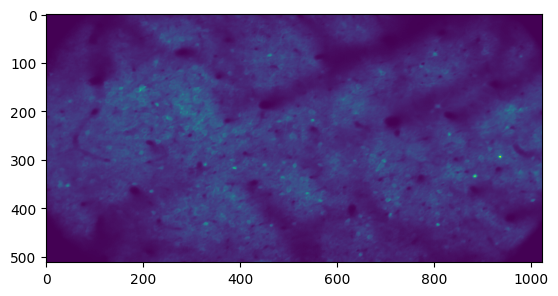

interactive(children=(IntSlider(value=0, description='i_frame', max=40), Output()), _dom_classes=('widget-inte…

In [27]:
plotting_helpers.display_toggle_image_stack(zstack_sparse)

In [28]:
import sparse

sf_sparse = sparse.COO(sf).reshape((sf.shape[0], frame_height, frame_width))
sf_neuropil_sparse = sparse.COO(sf_neuropil).reshape((sf_neuropil.shape[0], frame_height, frame_width))

# F_dZ    = (zstack_sparse[:,None,:,:] * sf_sparse[None,:,:,:]).sum(axis=(-2,-1)).todense()
F_dZ = ((zstack_sparse[:,None,:,:] * sf_sparse[None,:,:,:]).sum(axis=(-2,-1)) / sf_sparse.sum(axis=(-2,-1))).todense()
Fneu_dZ = ((zstack_sparse[:,None,:,:] * sf_neuropil_sparse[None,:,:,:]).sum(axis=(-2,-1)) / sf_neuropil_sparse.sum(axis=(-2,-1))).todense()

# FneuSub_dZ = F_dZ - Fneu_dZ*params['dFoF']['neuropil_fraction']

params['zstack']['sig_smooth_z'] = 1.5
# FneuSub_dZ_conv = timeSeries.simple_smooth(FneuSub_dZ, x=np.linspace(-FneuSub_dZ.shape[0]//2, FneuSub_dZ.shape[0]//2, FneuSub_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)
F_dZ_conv = timeSeries.simple_smooth(F_dZ, x=np.linspace(-F_dZ.shape[0]//2, F_dZ.shape[0]//2, F_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)
Fneu_dZ_conv = timeSeries.simple_smooth(Fneu_dZ, x=np.linspace(-Fneu_dZ.shape[0]//2, Fneu_dZ.shape[0]//2, Fneu_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)

results['zstack']['F_dZ'] = F_dZ
results['zstack']['Fneu_dZ'] = Fneu_dZ
results['zstack']['F_dZ_conv'] = F_dZ_conv
results['zstack']['Fneu_dZ_conv'] = Fneu_dZ_conv

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/sparse/_umath.py:647: RuntimeWarning: divide by zero encountered in divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in divide
  fill_value_array = self.func(


visually check out the trace and distribution of the z_positions time series to see where the 'baseline' / 0-point is

In [29]:
params['zstack']['z0_component'] = -1.7
params['zstack']['dZ_component'] = 6

idx_position_0 = np.abs(np.array(positions_z) + params['zstack']['z0_component']).argmin()
idx_position_plus = np.abs(np.array(positions_z) + params['zstack']['dZ_component']).argmin()
idx_position_minus = np.abs(np.array(positions_z) - params['zstack']['dZ_component']).argmin()

FoF_dZ_conv = F_dZ_conv / F_dZ_conv[idx_position_0]
FneuoF_dZ_conv = Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0]

FneuSub_dZ_conv = F_dZ_conv - 0.7*Fneu_dZ_conv
dFneuSuboF_dZ_conv = (FneuSub_dZ_conv - FneuSub_dZ_conv[idx_position_0]) / FneuSub_dZ_conv[idx_position_0]
# dFoF_dZ_conv = ((F_dZ_conv - Fneu_dZ_conv*0.7) - (F_dZ_conv - Fneu_dZ_conv*0.7)[idx_position_0]) / (F_dZ_conv - Fneu_dZ_conv*0.7)[idx_position_0]

component_z_plus = dFneuSuboF_dZ_conv[idx_position_plus]
component_z_minus = dFneuSuboF_dZ_conv[idx_position_minus]

results['zstack']['idx_position_0'] = idx_position_0
results['zstack']['idx_position_plus'] = idx_position_plus
results['zstack']['idx_position_minus'] = idx_position_minus
results['zstack']['FoF_dZ_conv'] = FoF_dZ_conv
results['zstack']['FneuoF_dZ_conv'] = FneuoF_dZ_conv
# results['zstack']['component_z_plus'] = component_z_plus
# results['zstack']['component_z_minus'] = component_z_minus

Text(0.5, 1.0, 'F or Fneu / dZ')

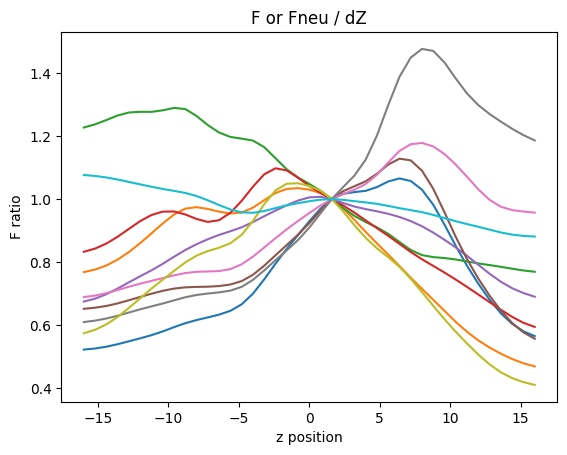

In [30]:
plt.figure()
# plt.plot(positions_z, F_dZ[:,:200]);
plt.plot(positions_z, (F_dZ_conv / F_dZ_conv[idx_position_0])[:,:10]);
# plt.plot(positions_z, Fneu_dZ[:,:200]);
# plt.plot(positions_z, (Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0])[:,:20]);
plt.xlabel('z position')
plt.ylabel('F ratio')
plt.title('F or Fneu / dZ')

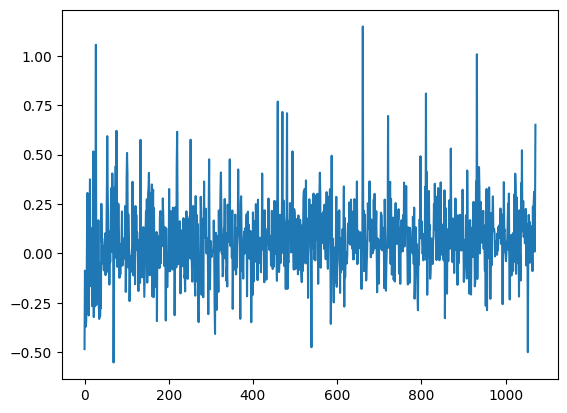

In [31]:
plt.figure()
plt.plot(component_z_plus[iscell])

Text(0.5, 1.0, 'F or Fneu / dZ')

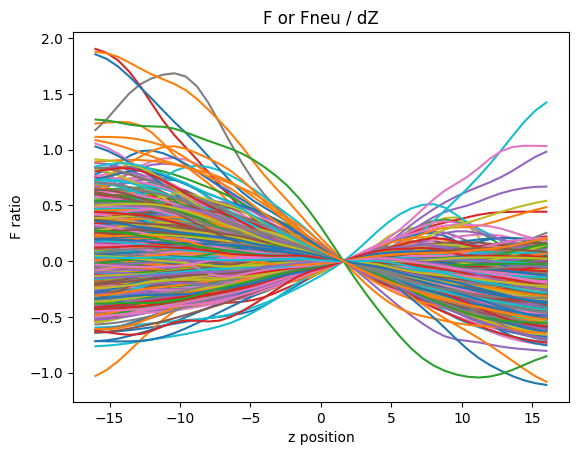

In [33]:
plt.figure()
# plt.plot(positions_z, F_dZ[:,:200]);
# plt.plot(positions_z, (F_dZ_conv / F_dZ_conv[idx_position_0])[:,:200]);
plt.plot(positions_z, dFneuSuboF_dZ_conv[:,iscell])
# plt.plot(positions_z, FneuSub_dZ_conv[:,iscell][:,:])
# plt.plot(positions_z, Fneu_dZ[:,:]);
# plt.plot(positions_z, (Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0])[:,:20]);
plt.xlabel('z position')
plt.ylabel('F ratio')
plt.title('F or Fneu / dZ')

<IPython.core.display.Javascript object>


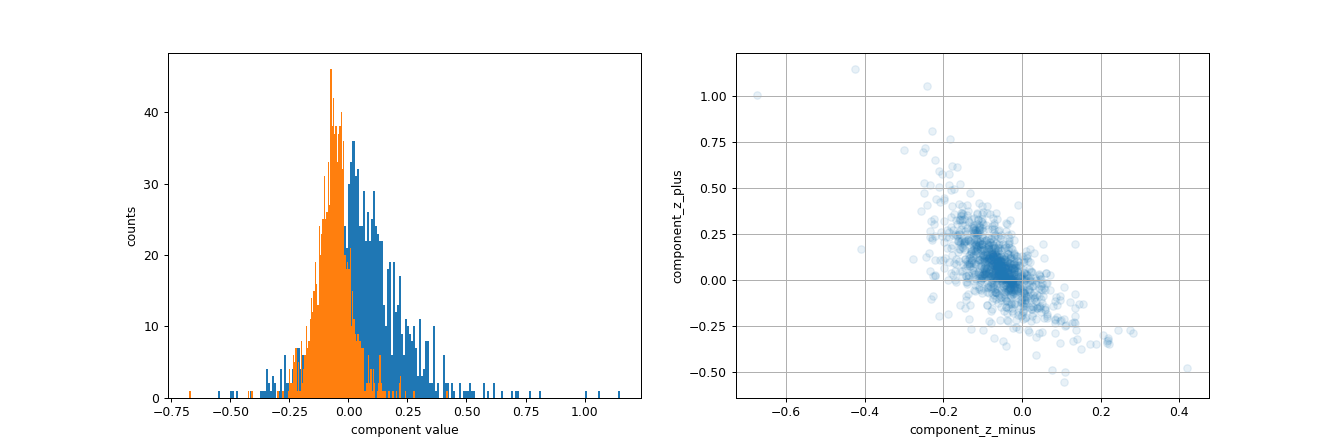

In [40]:
%matplotlib notebook

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(component_z_plus[iscell], 200);
axs[0].hist(component_z_minus[iscell], 200);
axs[0].set_xlabel('component value')
axs[0].set_ylabel('counts')

axs[1].scatter(component_z_minus[iscell], component_z_plus[iscell], alpha=0.1)
axs[1].grid()
axs[1].set_xlabel('component_z_minus')
axs[1].set_ylabel('component_z_plus');

In [41]:
np.argmin(component_z_plus[iscell])

69

In [44]:
component_z_plus.shape

(2979,)

Calculate the expected dF/F scaling factor at each time point for each ROI. Interpolate the expected `FneuSubOF_dZ` value for each neuron at the calculated z-position for that frame.

# Prepare dFoF

In [16]:
params['dFoF'] = {}

# params['dFoF']['max_z_displacement'] = 2.5


idx_time_bad = np.arange(0,15000)
# idx_time_bad =+ np.where(np.abs(z_positions) > params['dFoF']['max_z_displacement'])[0]

idx_time_good = np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

results['idx_time_bad'] = idx_time_bad

print(f'num excluded time points: {len(idx_time_bad)}')

num excluded time points: 15000


In [17]:
F_toUse = F[iscell][:, idx_time_good]
Fneu_toUse = Fneu[iscell][:, idx_time_good]

In [70]:
params['dFoF']['channelOffset_correction'] = tqm['dFoF_params']['channelOffset_correction']
params['dFoF']['percentile_baseline'] = tqm['dFoF_params']['percentile_baseline']
params['dFoF']['neuropil_fraction'] = tqm['dFoF_params']['neuropil_fraction']
params['dFoF']['win_rolling_percentile'] = int(10*60*results['data']['Fs'])  ## In frames
params['dFoF']['roll_stride'] = 10  ## In frames

In [19]:
# dFoF with reduced percentile for baseline

dFoF, dF, F_neuSub, F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=params['dFoF']['neuropil_fraction'],
    percentile_baseline=params['dFoF']['percentile_baseline'],
    rolling_percentile_window=int(params['dFoF']['win_rolling_percentile']),
    channelOffset_correction=params['dFoF']['channelOffset_correction'],
    roll_stride=params['dFoF']['roll_stride'],
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|███████████████████████████████████████████| 36/36 [00:09<00:00,  3.88it/s]


Calculated dFoF. Total elapsed time: 10.74 seconds


In [20]:
np.sum(dFoF > 30)

0

In [21]:
# dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [53]:
import rastermap

In [54]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [64]:
# X = scipy.stats.zscore(dFoF, axis=0).T
# X = scipy.stats.zscore(dFoF, axis=1)
# X = dFoF / np.std(dFoF, axis=1, keepdims=True)
X = dFoF.copy()
rmap.fit(X)

nmin 200
0.13536620140075684
5.692404270172119
6.057732105255127
6.060520172119141
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.2012      2
0.14s    10        0.3278      4
0.24s    20        0.3531      8
0.36s    30        0.3818      18
0.48s    40        0.4074      28
0.59s    50        0.4343      38
0.71s    60        0.4355      38
0.79s   final      0.4355
0.79s upsampled    0.4355


<IPython.core.display.Javascript object>


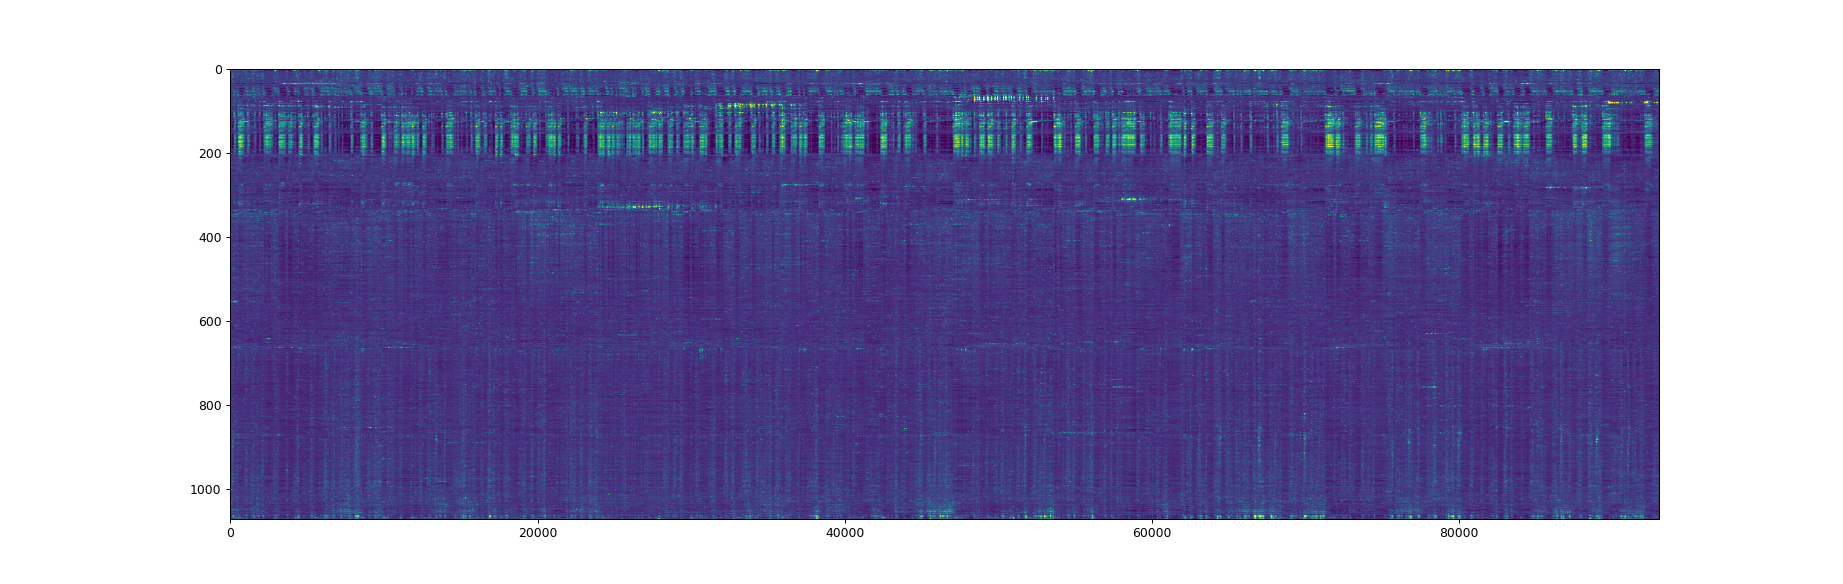

In [68]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort][:], aspect='auto', vmin=-0.1, vmax=1)

# %matplotlib inline

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [22]:
params['preorthogonalization'] = {}

params['preorthogonalization']['bandpass_freqs_boundaries'] = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]
params['preorthogonalization']['mspline_grid_order'] = 3
params['preorthogonalization']['mspline_grid_numSplines'] = 4
params['preorthogonalization']['num_taps'] = 10001
params['preorthogonalization']['window'] = ('kaiser', 3.0)

In [23]:
dFoF_mean = np.nanmean(dFoF, axis=0)
Fneu_mean = np.nanmean(Fneu_toUse, axis=0)

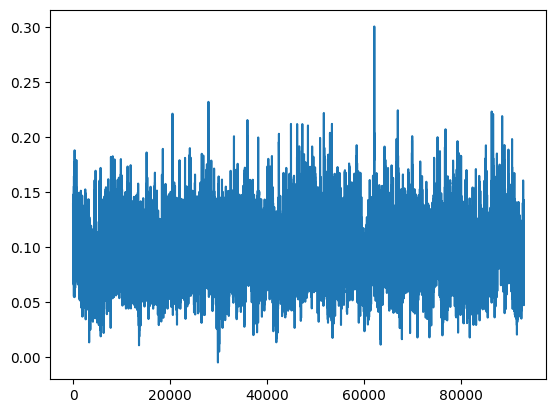

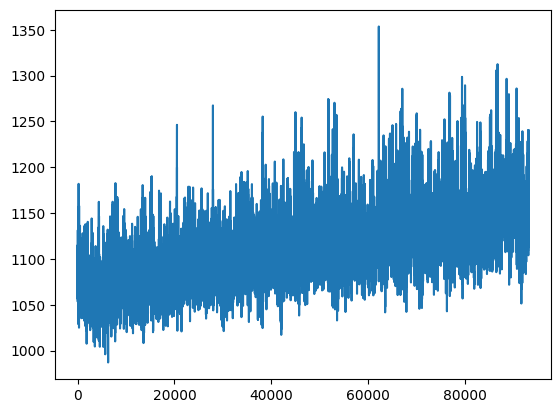

In [24]:
plt.figure()
plt.plot(dFoF_mean)

plt.figure()
plt.plot(Fneu_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [25]:
bpfb = params['preorthogonalization']['bandpass_freqs_boundaries'] 

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=params['preorthogonalization']['num_taps'], fs=Fs, window=params['preorthogonalization']['window'], plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bpfb[:-1], bpfb[1:]))]

In [26]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

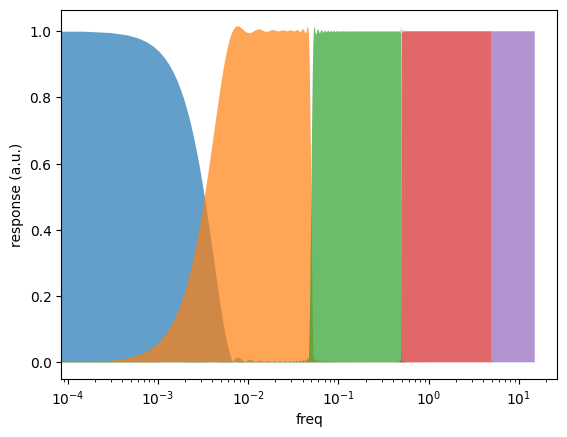

In [27]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [28]:
sigs = np.stack(
    [scipy.signal.filtfilt(h, 1.0, dFoF_mean - dFoF_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_mean - Fneu_mean.mean()) for h in tqdm(bandpass_ab[:])] + \
    [np.linspace(-1, 1, dFoF.shape[1], endpoint=True)] + \
    [np.ones(dFoF.shape[1])] + \
    list(featurization.mspline_grid(order=params['preorthogonalization']['mspline_grid_order'], num_basis_funcs=params['preorthogonalization']['mspline_grid_numSplines'], nt=dFoF.shape[1])),
    
    axis=0
).astype(np.float32)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


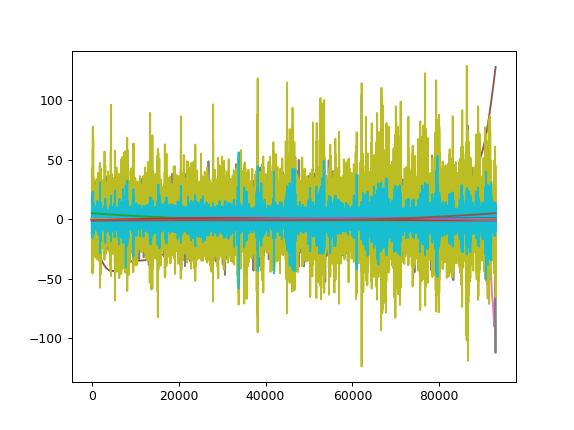

<IPython.core.display.Javascript object>


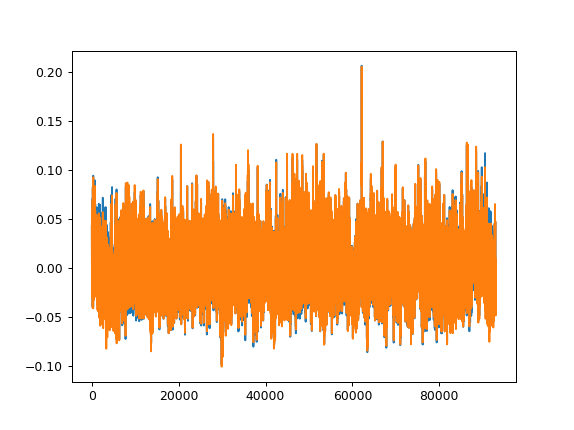

In [29]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

# %matplotlib inline

In [32]:
v1_orth, EVR, EVR_total, pca_dict = similarity.orthogonalize((dFoF - dFoF_mean).T, sigs.T, method='OLS', device=device)

dFoF_orth = v1_orth.T - np.percentile(v1_orth.T, params['dFoF']['percentile_baseline'], axis=1)[:,None]

print(f"Total variance ratio in dFoF orthogonalized out: {EVR_total :.4f}")

Total variance ratio in dFoF orthogonalized out: 0.1171


In [33]:
results['preorthogonalization'] = {}

results['preorthogonalization']['signals'] = sigs
results['preorthogonalization']['EVR_total'] = EVR_total
results['preorthogonalization']['dFoF_mean'] = dFoF_mean
results['preorthogonalization']['Fneu_mean'] = Fneu_mean

In [79]:
import rastermap

In [80]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [81]:
X = dFoF_orth.copy()
# X = dFoF_orth / np.std(dFoF_orth, axis=1, keepdims=True)
# X = timeSeries.simple_smooth(X, sig=4, axis=1)
rmap.fit(X)

nmin 200
0.2997932434082031
8.880519151687622
9.469635963439941
9.473199129104614
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.0360      2
0.10s    10        0.1509      4
0.18s    20        0.1913      8
0.30s    30        0.2378      18
0.42s    40        0.2779      28
0.50s    50        0.3096      38
0.63s    60        0.3103      38
0.69s   final      0.3103
0.69s upsampled    0.3103


<IPython.core.display.Javascript object>


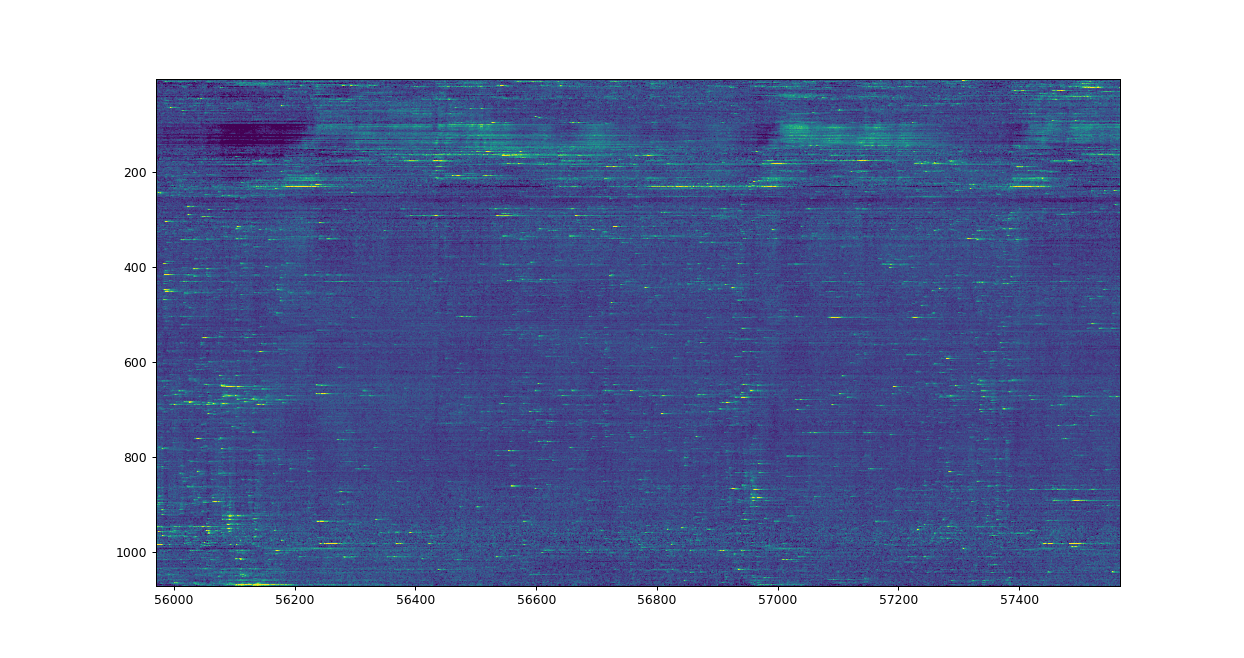

In [82]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)

# %matplotlib inline

In [84]:
params['rank'] = 6

params['spca'] = {}
# params['spca']['alphas'] = [10, 20, 40, 60, 100]
# params['spca']['alphas'] = [20, 40, 60,]
# params['spca']['alphas'] = [7, 9, 12]
params['spca']['alphas'] = [13, 15, 17]

params['spca']['tol_sweep'] = 1e-4
params['spca']['tol_final'] = 1e-6

params['spca']['n_neurons_nonZero_goal'] = dFoF.shape[0] * 0.05
print(f"n_neurons_nonZero_goal: {params['spca']['n_neurons_nonZero_goal']}")

neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

n_neurons_nonZero_goal: 53.6


In [85]:
U, S, V = torch.svd(torch.as_tensor(neural_data_toUse.T, device=device, dtype=torch.float32), some=True)
U, S, V = U.cpu().numpy(), S.cpu().numpy(), V.cpu().numpy()
U, V = sklearn.utils.extmath.svd_flip(U, V)

spca_partials = partial(sklearn.decomposition.SparsePCA, n_components=6, ridge_alpha=0.01, max_iter=1000, method='lars', n_jobs=None, U_init=U, V_init=V, verbose=True, random_state=None)

In [86]:
spcas = {alpha: spca_partials(alpha=alpha, tol=params['spca']['tol_sweep'],) for alpha in params['spca']['alphas']}

[spca.fit(neural_data_toUse.T) for spca in tqdm(spcas.values())];

  0%|          | 0/3 [00:00<?, ?it/s]

[dict_learning] .............
[dict_learning] .............
[dict_learning] ................


In [87]:
n_neurons_nonZero = {alpha: (s.components_ != 0).sum(1).mean() for alpha,s in spcas.items()}

idx_alpha_toUse = np.abs((np.array(list(n_neurons_nonZero.values())) - params['spca']['n_neurons_nonZero_goal'])).argmin()

alpha_toUse = list(n_neurons_nonZero.keys())[idx_alpha_toUse]

In [88]:
print('Number of nonzero components for neuron loadings')
print(f"Goal number of nonzero neurons: {params['spca']['n_neurons_nonZero_goal'] :.1f}")
[print(f"alpha: {key}: {val :.1f}") for key,val in n_neurons_nonZero.items()];

Number of nonzero components for neuron loadings
Goal number of nonzero neurons: 53.6
alpha: 13: 24.3
alpha: 15: 20.0
alpha: 17: 16.5


<IPython.core.display.Javascript object>


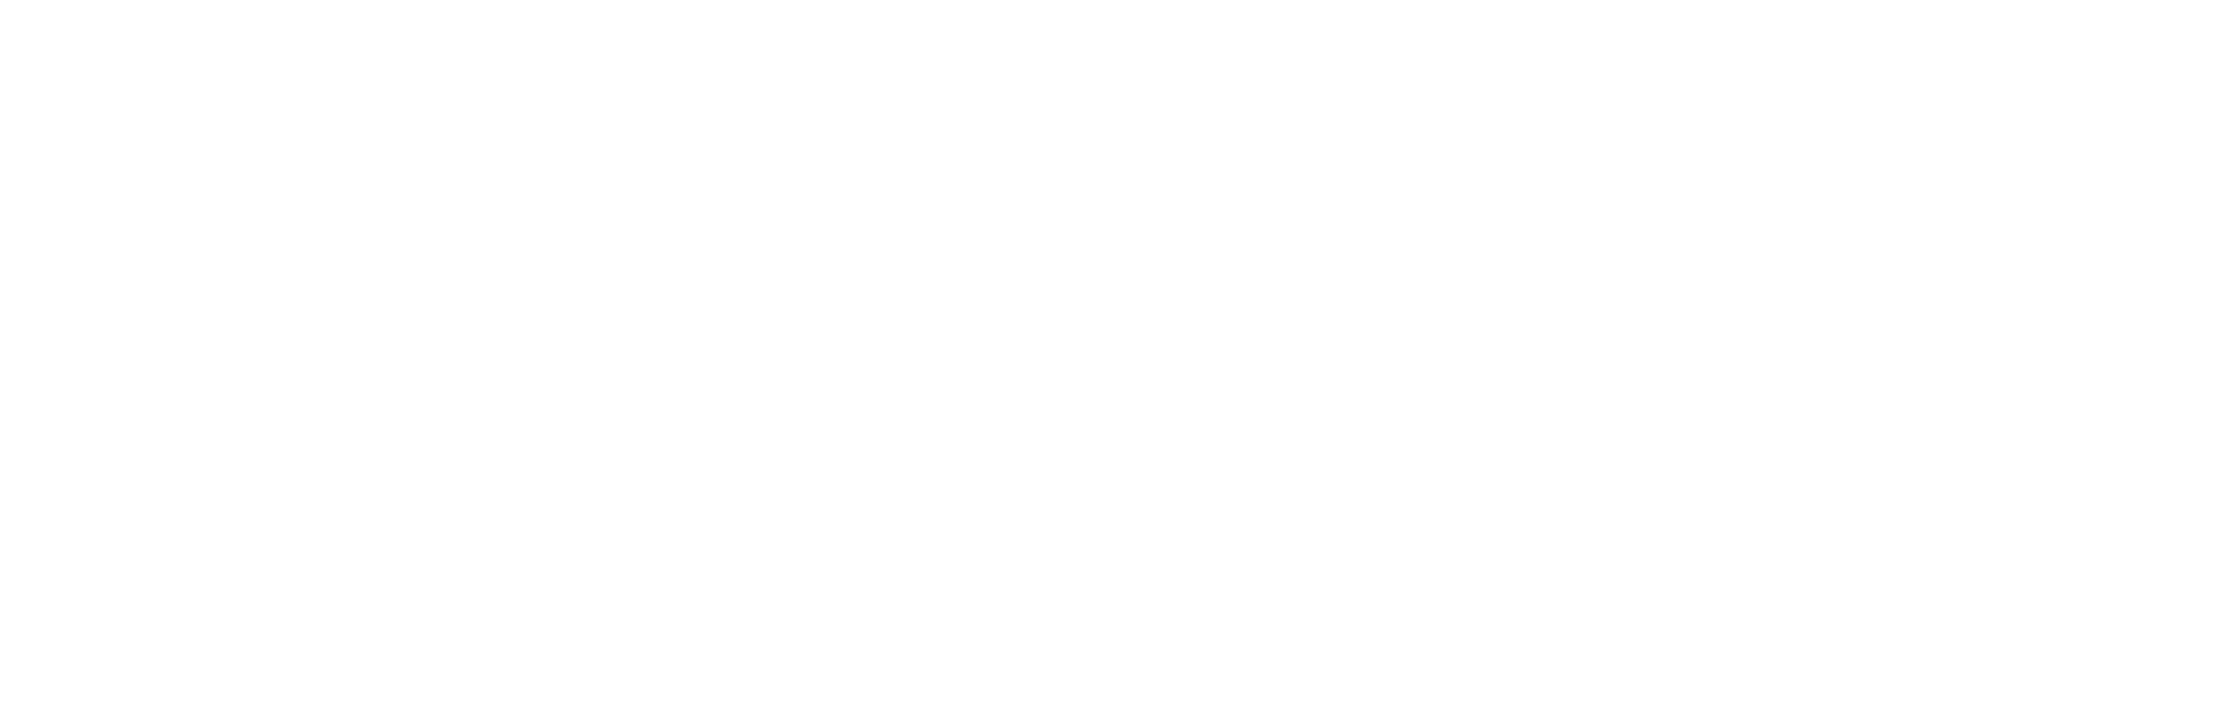

<IPython.core.display.Javascript object>


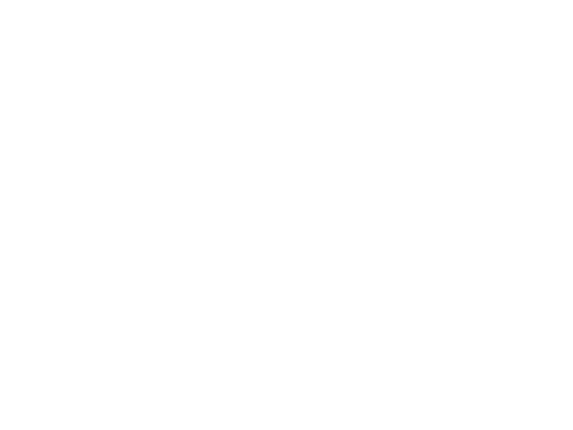

Text(0.5, 1.0, 'Correlations of scores onto dFoF. Alpha = 15')

In [89]:
idx_alpha_toShow = 1

plt.figure(figsize=(25,8))
plt.plot(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T) + np.arange(params['rank'])*10*spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).std(1).mean());
plt.title(f"Scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

plt.figure()
plt.imshow(np.corrcoef(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).T), cmap='bwr', vmin=-1, vmax=1);
plt.title(f"Correlations of scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

In [90]:
print(f"Running final SPCA at a lower tolerance with alpha={alpha_toUse}")
tic = time.time()

spca = spca_partials(alpha=alpha_toUse, tol=params['spca']['tol_final'])
scores = spca.fit_transform(neural_data_toUse.T)

print(f"Duration: {time.time() - tic:.2f}s")

Running final SPCA at a lower tolerance with alpha=13
[dict_learning] ..................
Duration: 25.25s


In [91]:
results['spca'] = {}

results['spca']['alpha_toUse'] = alpha_toUse
results['spca']['objs_alphaSweep'] = {alpha: spca.__dict__ for alpha,spca in spcas.items()}
results['spca']['spca_obj'] = copy.deepcopy(spca.__dict__)
results['spca']['num_nonzero_neurons'] = (spca.components_ != 0).sum(1)

In [92]:
print(f'Number of nonzero components for neuron loadings:')
print(f"Mean: {results['spca']['num_nonzero_neurons'].mean() :.1f}")
print(f"Components: {results['spca']['num_nonzero_neurons']}")

Number of nonzero components for neuron loadings:
Mean: 24.0
Components: [72 28 19 10 11  4]


<IPython.core.display.Javascript object>


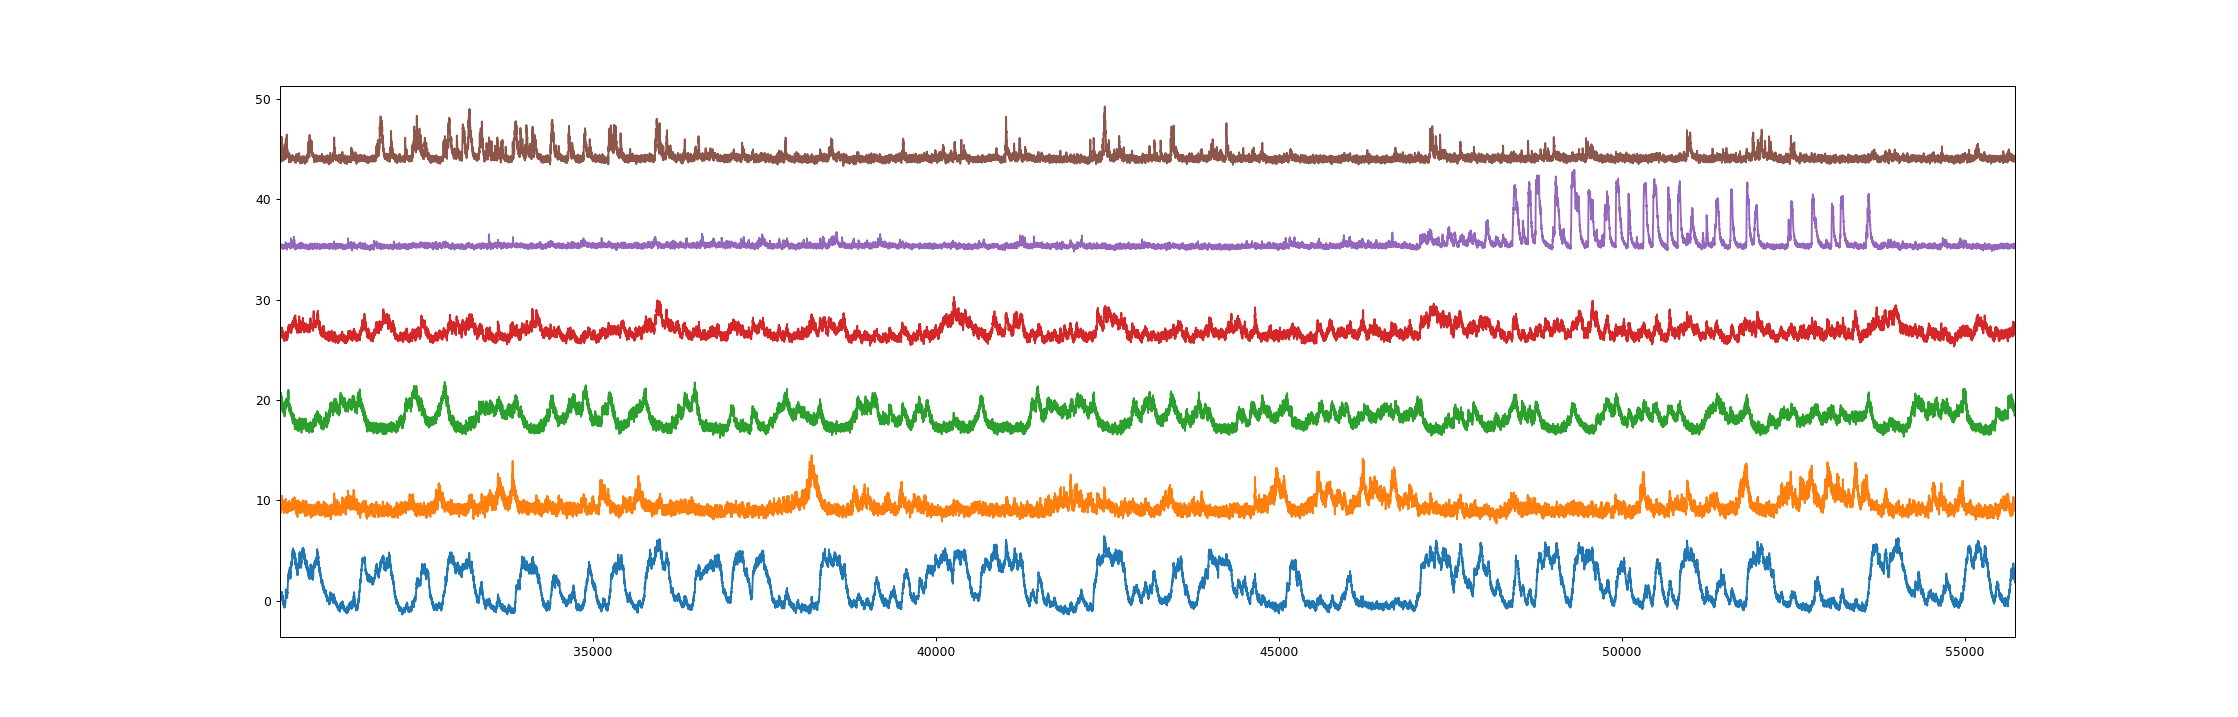

<IPython.core.display.Javascript object>


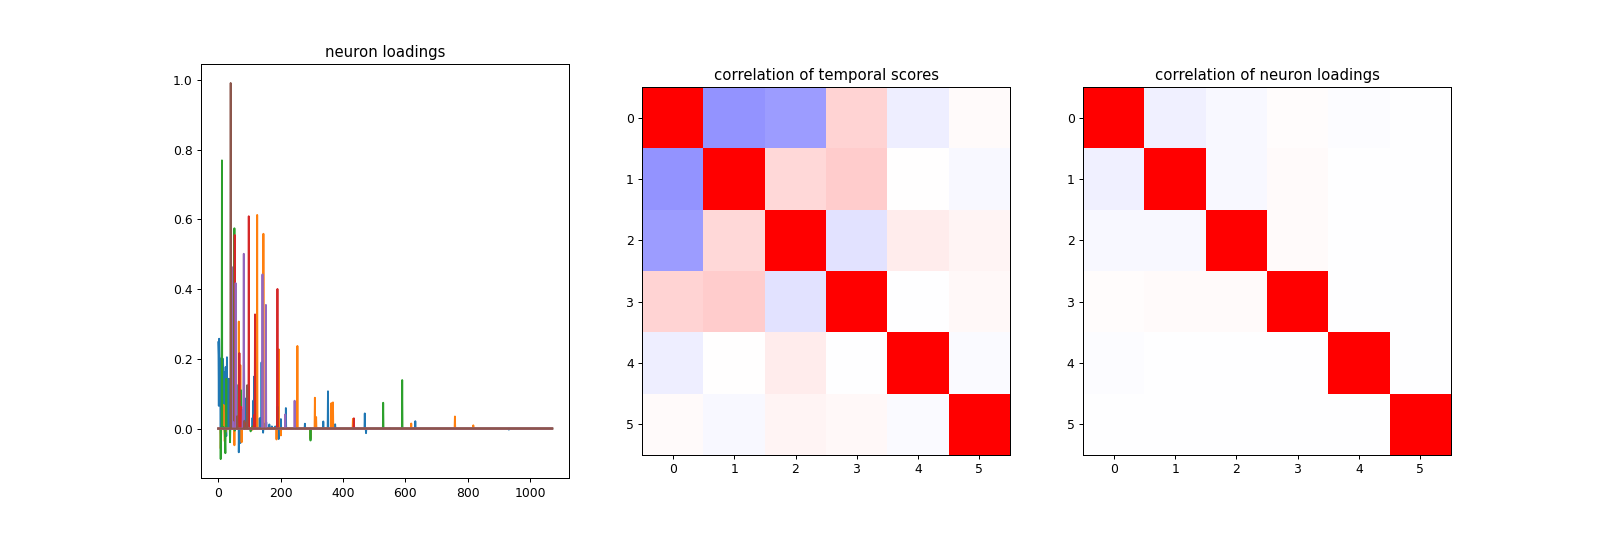

Text(0.5, 1.0, 'correlation of neuron loadings')

In [97]:
plt.figure(figsize=(25,8))
plt.plot(spca.transform(dFoF.T) + np.arange(params['rank'])*10*spca.transform(dFoF.T).std(1).mean());

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(results['spca']['spca_obj']['components_'].T);
axs[0].set_title('neuron loadings')
axs[1].imshow(np.corrcoef(scores.T), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title('correlation of temporal scores')
axs[2].imshow(np.corrcoef(results['spca']['spca_obj']['components_']), cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('correlation of neuron loadings')

<IPython.core.display.Javascript object>


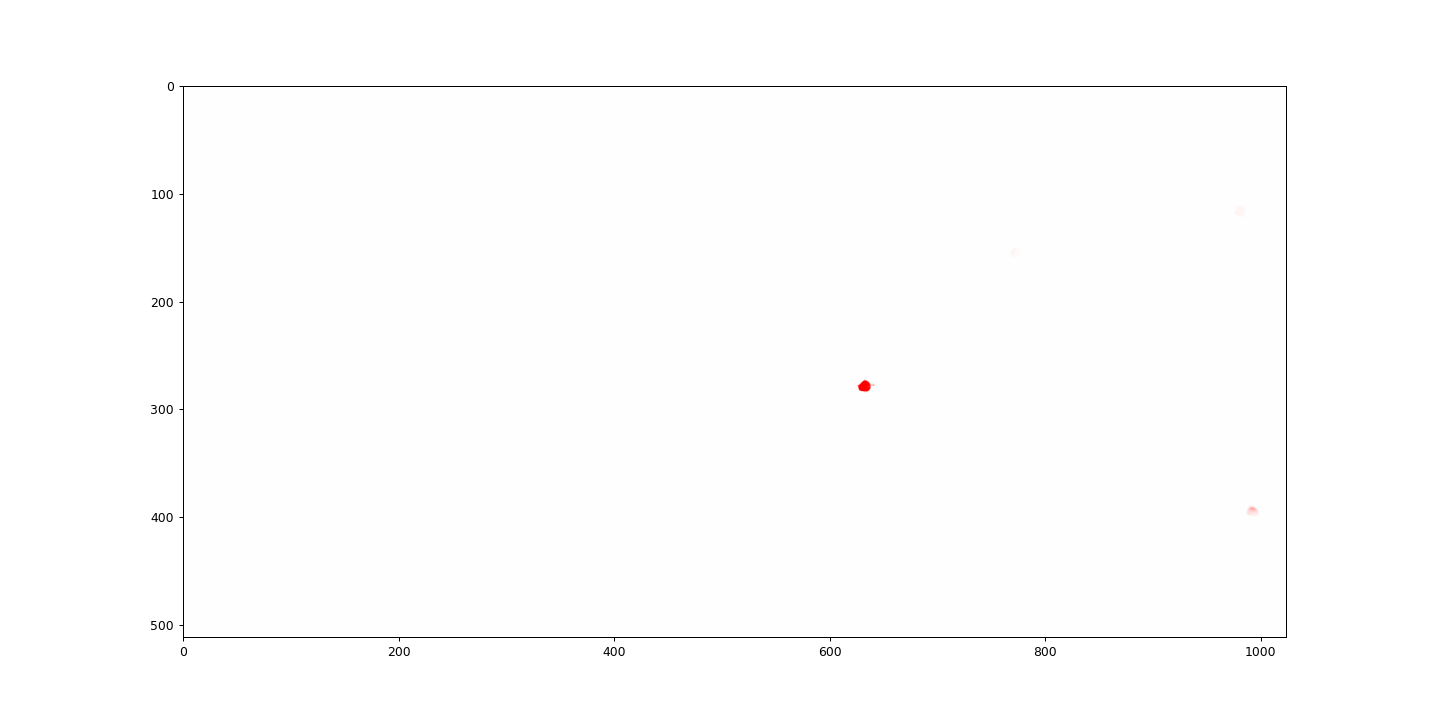

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [96]:
weights = results['spca']['spca_obj']['components_'].copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(params['rank'], frame_height, frame_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

In [37]:
test['results']['factors'].keys()

dict_keys(['factors_original', 'factors_regressed', 'factors_orth', 'factors_orth_ms', 'factors_orth_ms_norm', 'factors_orth_ms_norm_flipped', 'factors_orth_ms_norm_ordered', 'factors_final', 'scores_original', 'scores_regressed', 'scores_orth', 'scores_orth_ms_norm_raw', 'scores_orth_ms_norm_flipped_raw', 'scores_orth_ms_norm_raw_ordered', 'scores_final'])

In [38]:
factors_original = test['results']['factors']['factors_original'].copy()  ## shape (n_components, n_neurons)

In [40]:
neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

In [98]:
factors_original = results['spca']['spca_obj']['components_'].copy()  ## shape (n_components, n_neurons)

In [41]:
scores_original = (neural_data_toUse.T @ factors_original.T).T  ## shape (n_components, n_timepoints)

In [42]:
factors_regressed, scores_regressed, bias = linear_regression.Ridge(neural_data_toUse.T, scores_original.T, lam=1*10**6, add_bias_terms=True)
factors_regressed = factors_regressed.T
scores_regressed = scores_regressed.T

In [43]:
factors_orth = bmi_idap.helpers.orthogonalize_matrix(factors_regressed)  ## shape (n_components, n_neurons)

In [44]:
scores_orth = (neural_data_toUse.T @ factors_orth.T).T  ## shape (n_components, n_timepoints)

In [45]:
factors_orth_ms = factors_orth - factors_orth.mean(1, keepdims=True)  ## shape (n_components, n_neurons)

In [46]:
factors_orth_ms_norm = factors_orth_ms / factors_orth_ms.std(1, keepdims=True)  ## shape (n_components, n_neurons)
scores_orth_ms_norm_raw = (dFoF.T @ factors_orth_ms_norm.T).T  ## shape (n_components, n_timepoints)

In [47]:
factors_orth_ms_norm_flipped = factors_orth_ms_norm * np.sign(scipy.stats.skew(scores_orth_ms_norm_raw, axis=1))[:,None]
scores_orth_ms_norm_flipped_raw = (dFoF.T @ factors_orth_ms_norm_flipped.T).T  ## shape (n_components, n_timepoints)

In [102]:
_, order, EVR = bmi_idap.helpers.order_factors_by_EVR(dFoF, factors_orth_ms_norm_flipped, device=device)  

In [49]:
factors_orth_ms_norm_flipped_ordered = factors_orth_ms_norm_flipped[order]
scores_orth_ms_norm_flipped_ordered_raw = (neural_data_toUse.T @ factors_orth_ms_norm_flipped_ordered.T).T  ## shape (n_components, n_timepoints)

In [50]:
factors_final = factors_orth_ms_norm_flipped_ordered.copy()
scores_final = (dFoF.T @ factors_final.T).T  ## shape (n_components, n_timepoints)

In [51]:
results['factors'] = {}

results['factors']['factors_original'] = factors_original
results['factors']['factors_regressed'] = factors_regressed
results['factors']['factors_orth'] = factors_orth
results['factors']['factors_orth_ms'] = factors_orth_ms
results['factors']['factors_orth_ms_norm'] = factors_orth_ms_norm
results['factors']['factors_orth_ms_norm_flipped'] = factors_orth_ms_norm_flipped
results['factors']['factors_orth_ms_norm_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['factors_final'] = factors_final

results['factors']['scores_original'] = scores_original
results['factors']['scores_regressed'] = scores_regressed
results['factors']['scores_orth'] = scores_orth
results['factors']['scores_orth_ms_norm_raw'] = scores_orth_ms_norm_raw
results['factors']['scores_orth_ms_norm_flipped_raw'] = scores_orth_ms_norm_flipped_raw
results['factors']['scores_orth_ms_norm_raw_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['scores_final'] = scores_final


<IPython.core.display.Javascript object>


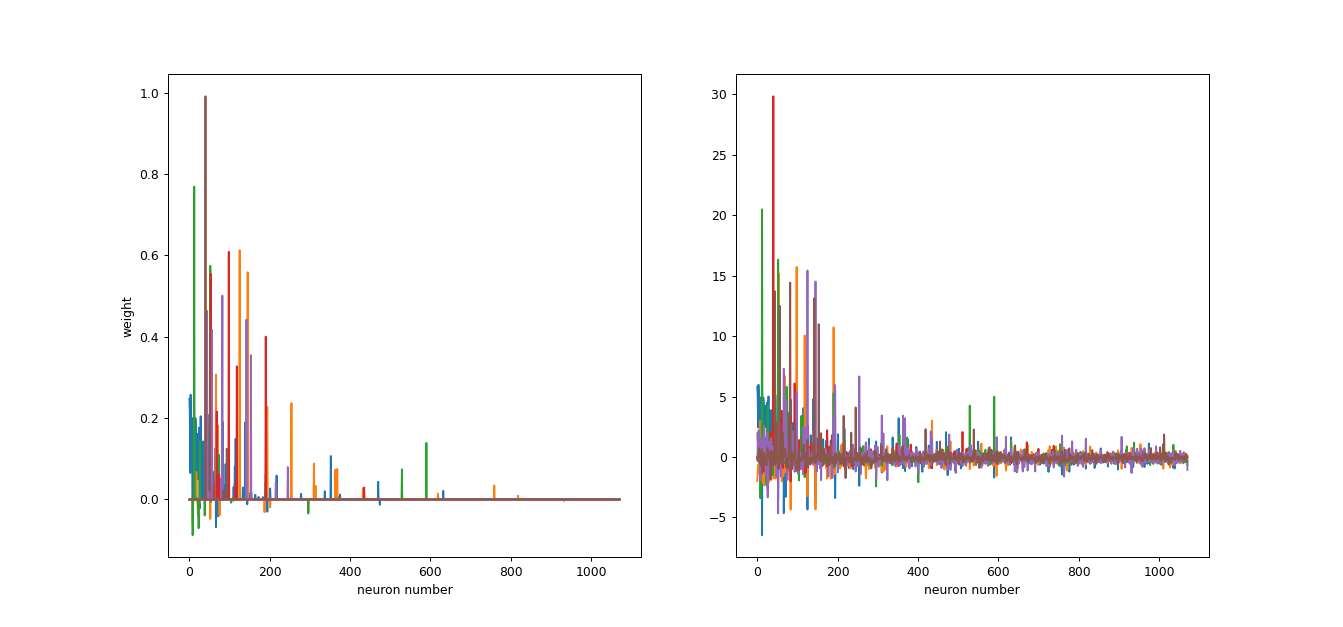

In [193]:
fig, axs = plt.subplots(1,2, figsize=(15, 7), sharex=True)
axs[0].plot(factors_original.T)
axs[0].set_ylabel('weight')
axs[0].set_xlabel('neuron number')
axs[1].plot(factors_final.T)
axs[1].set_xlabel('neuron number');

<IPython.core.display.Javascript object>


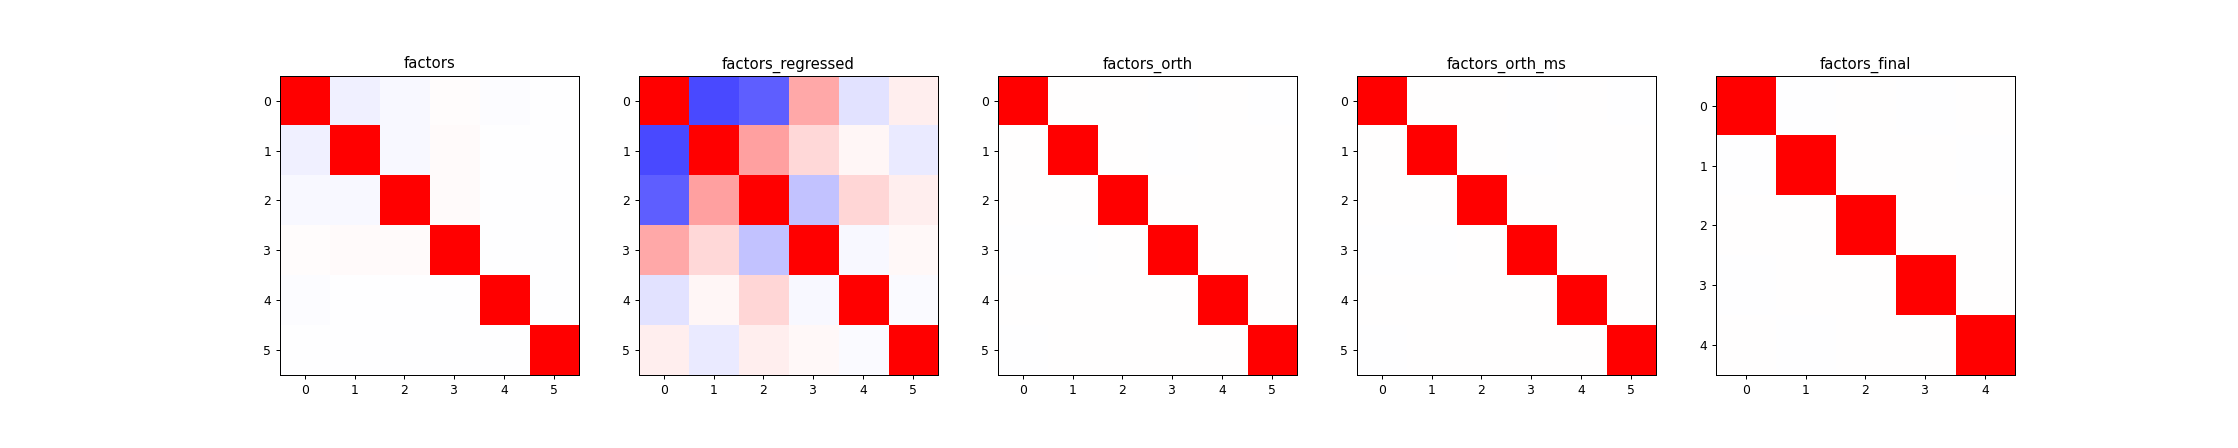

In [194]:
fig, axs = plt.subplots(1, 5, figsize=(25,5))
axs[0].imshow(np.corrcoef(factors_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('factors')
axs[1].imshow(np.corrcoef(factors_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('factors_regressed')
axs[2].imshow(np.corrcoef(factors_orth), cmap='bwr', clim=[-1,1])
axs[2].set_title('factors_orth')
axs[3].imshow(np.corrcoef(factors_orth_ms), cmap='bwr', clim=[-1,1])
axs[3].set_title('factors_orth_ms')
axs[4].imshow(np.corrcoef(factors_final[:-1]), cmap='bwr', clim=[-1,1])
axs[4].set_title('factors_final');

<IPython.core.display.Javascript object>


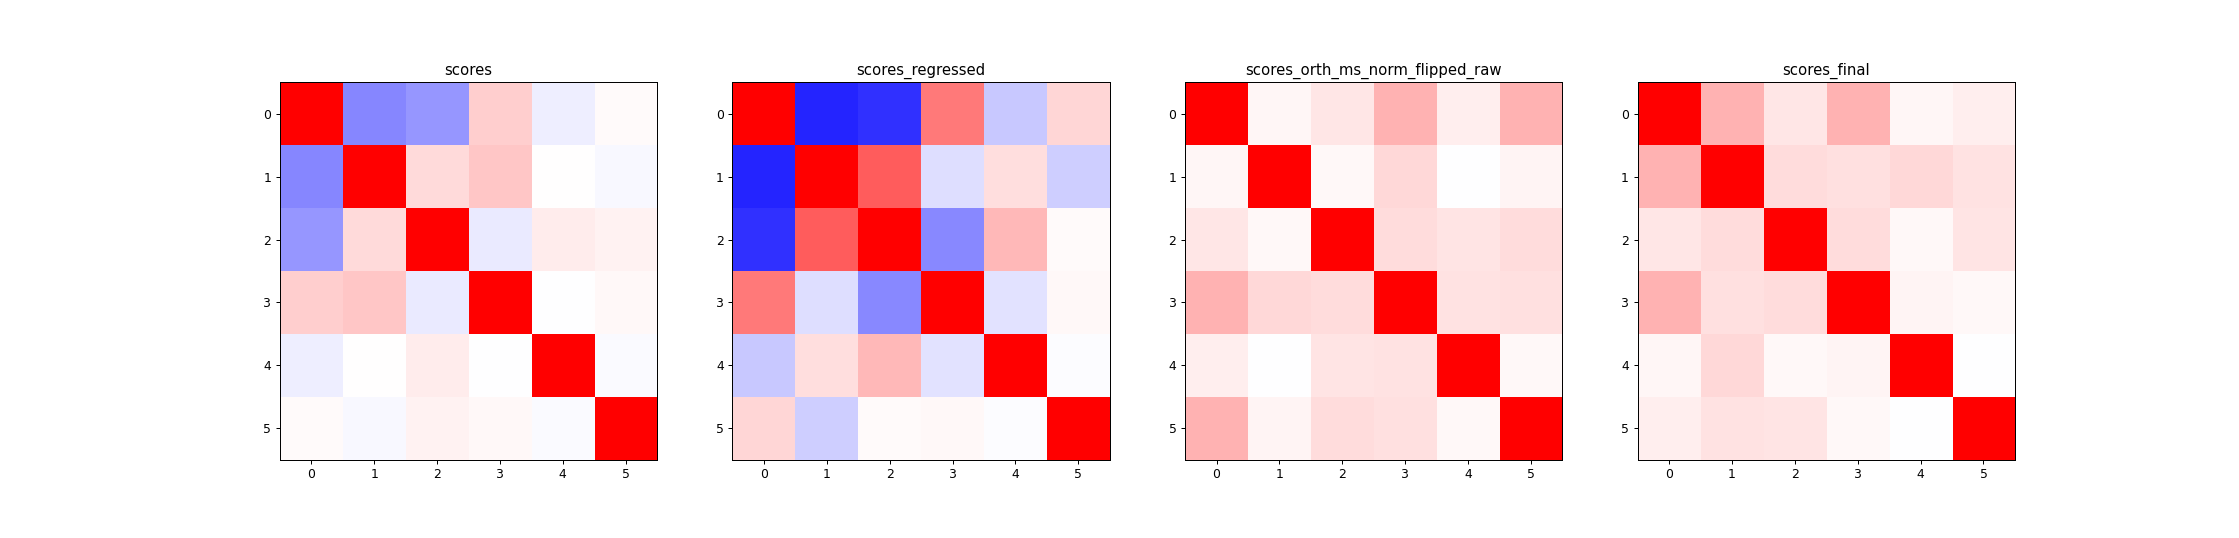

Text(0.5, 1.0, 'scores_final')

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(25,6))
axs[0].imshow(np.corrcoef(scores_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('scores')
axs[1].imshow(np.corrcoef(scores_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('scores_regressed')
axs[2].imshow(np.corrcoef(scores_orth_ms_norm_flipped_raw), cmap='bwr', clim=[-1,1])
axs[2].set_title('scores_orth_ms_norm_flipped_raw')
axs[3].imshow(np.corrcoef(scores_final), cmap='bwr', clim=[-1,1])
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>


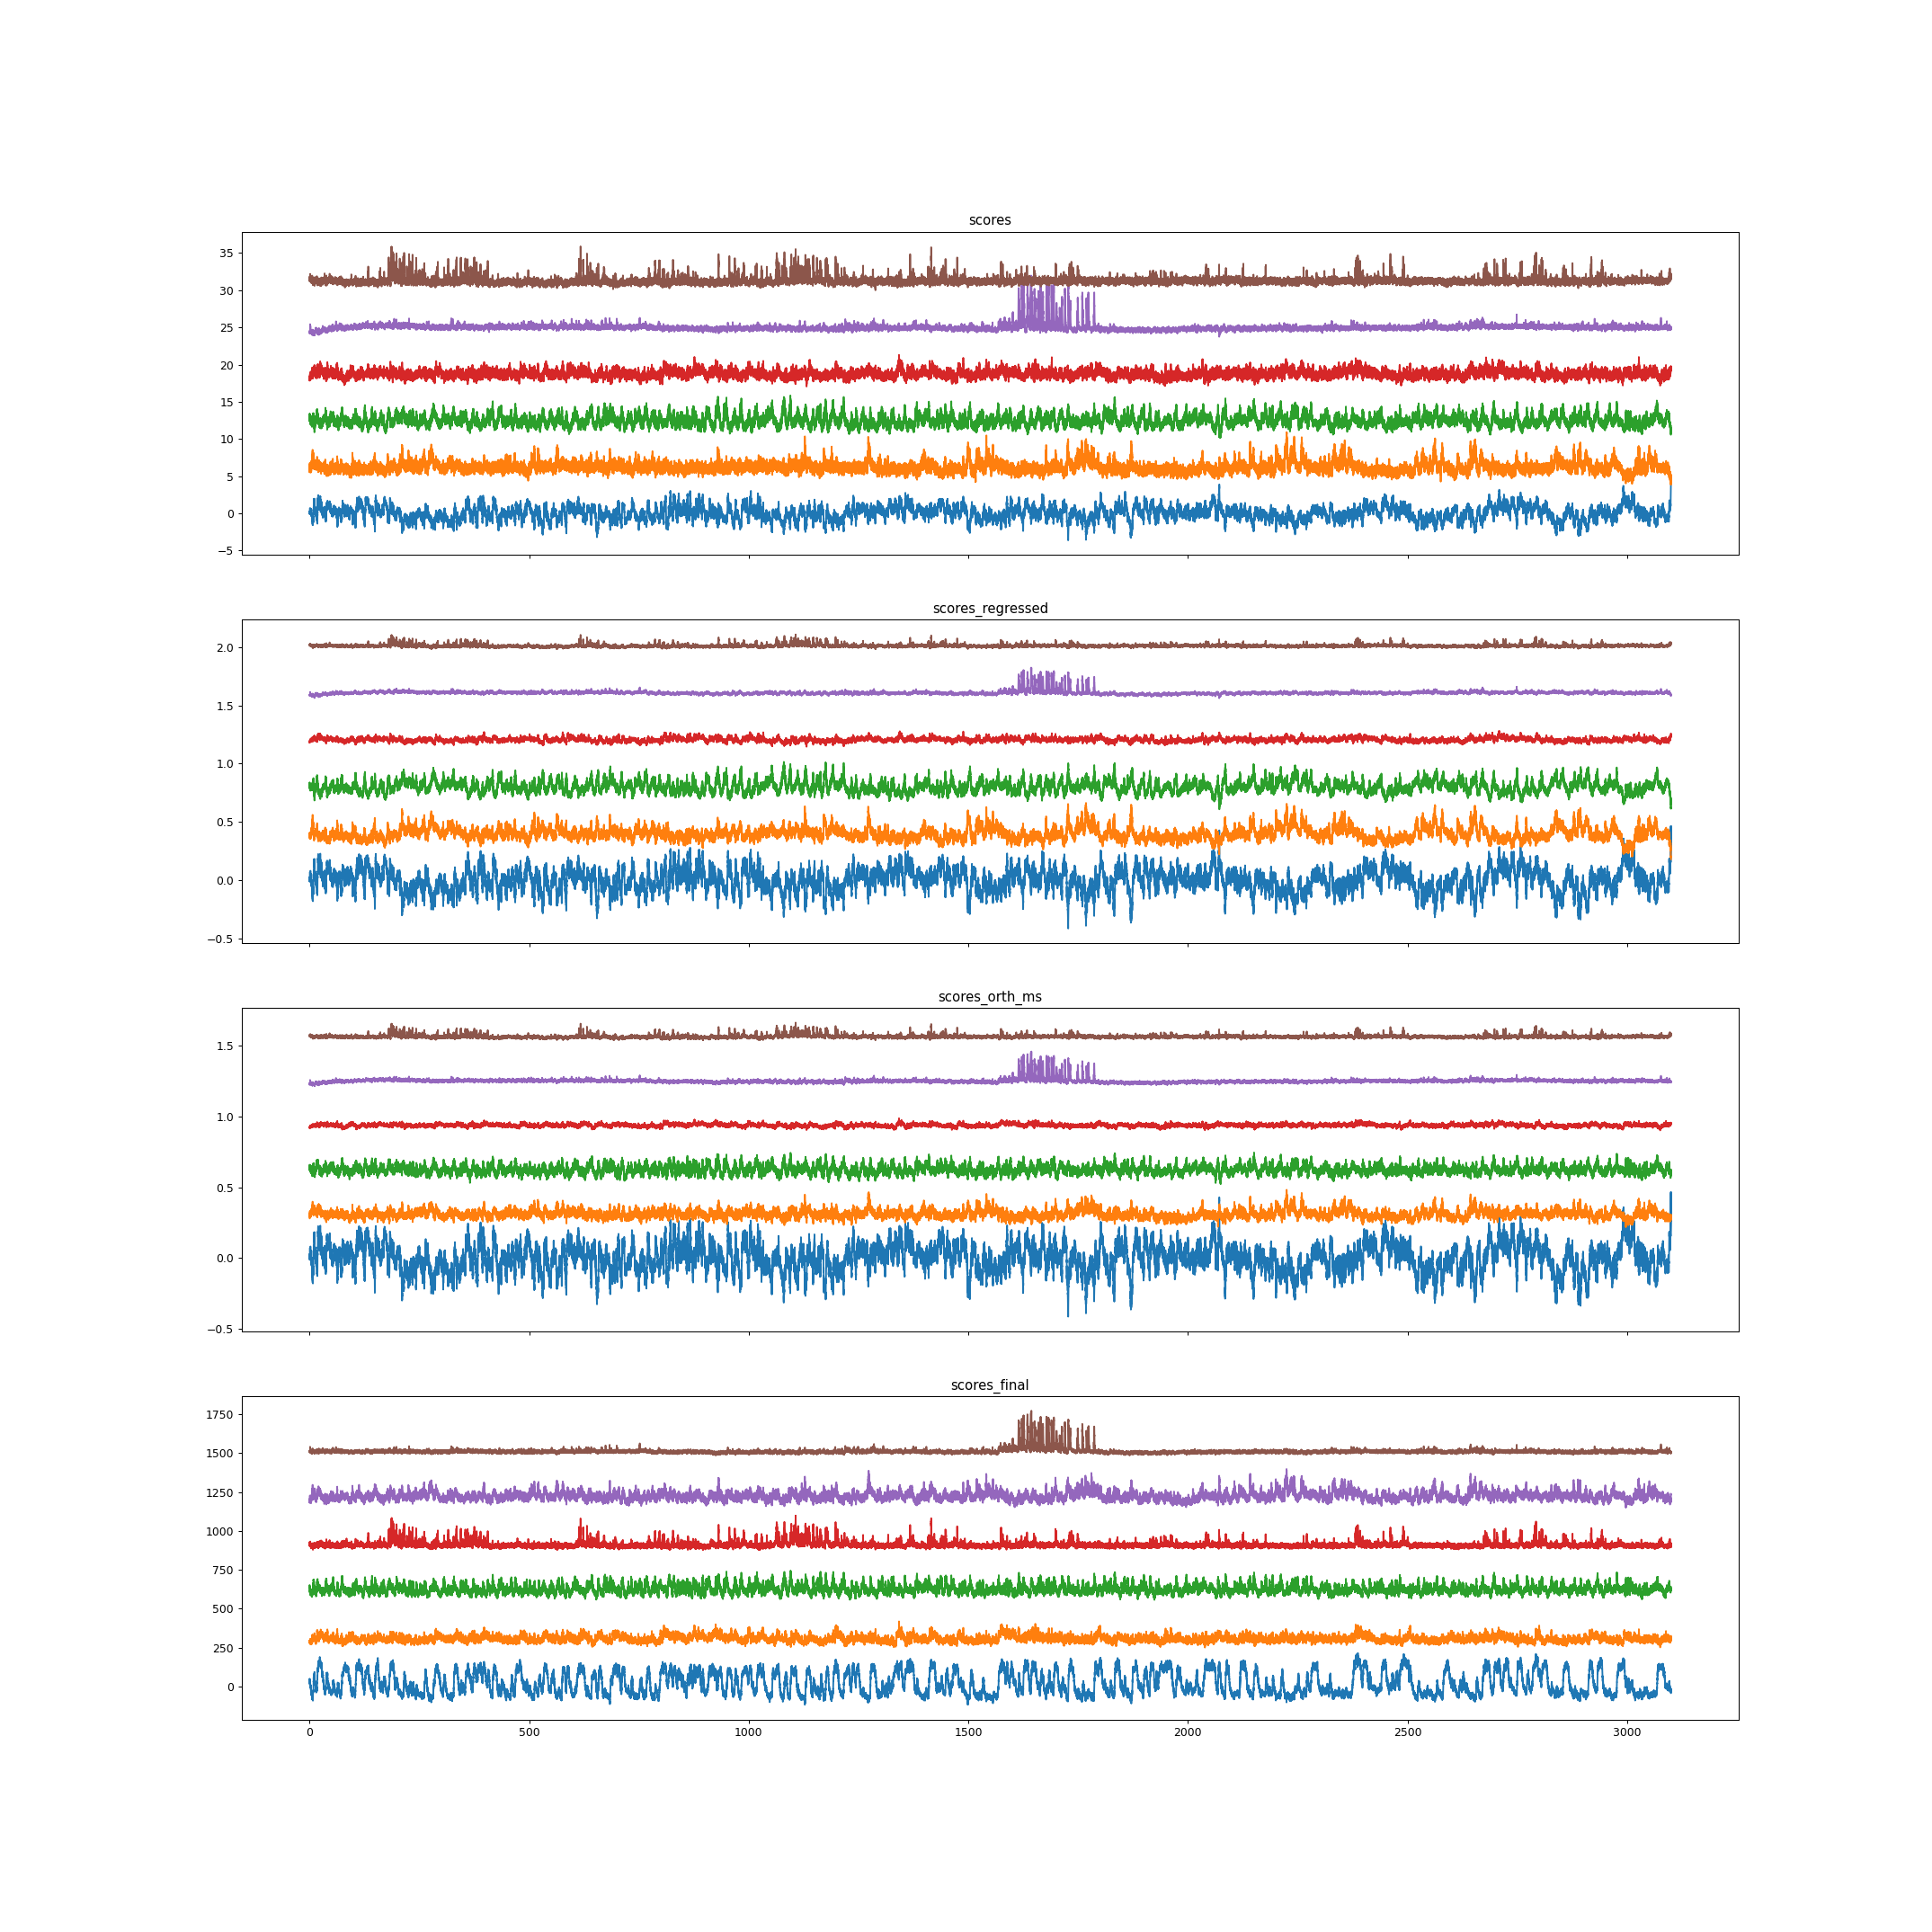

Text(0.5, 1.0, 'scores_final')

In [197]:
fig, axs = plt.subplots(4, 1, figsize=(24,24), sharex=True)
axs[0].plot(np.arange(scores_original.shape[1])/Fs,  scores_original.T + 10*scores_original.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[0].set_title('scores')
axs[1].plot(np.arange(scores_original.shape[1])/Fs,  scores_regressed.T + 10*scores_regressed.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[1].set_title('scores_regressed')
axs[2].plot(np.arange(scores_original.shape[1])/Fs,  scores_orth.T + 10*scores_orth.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[2].set_title('scores_orth_ms')
axs[3].plot(np.arange(scores_original.shape[1])/Fs,  scores_final.T + 10*scores_final.std(1).mean()*(np.arange(params['rank']))[None,:]);
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>


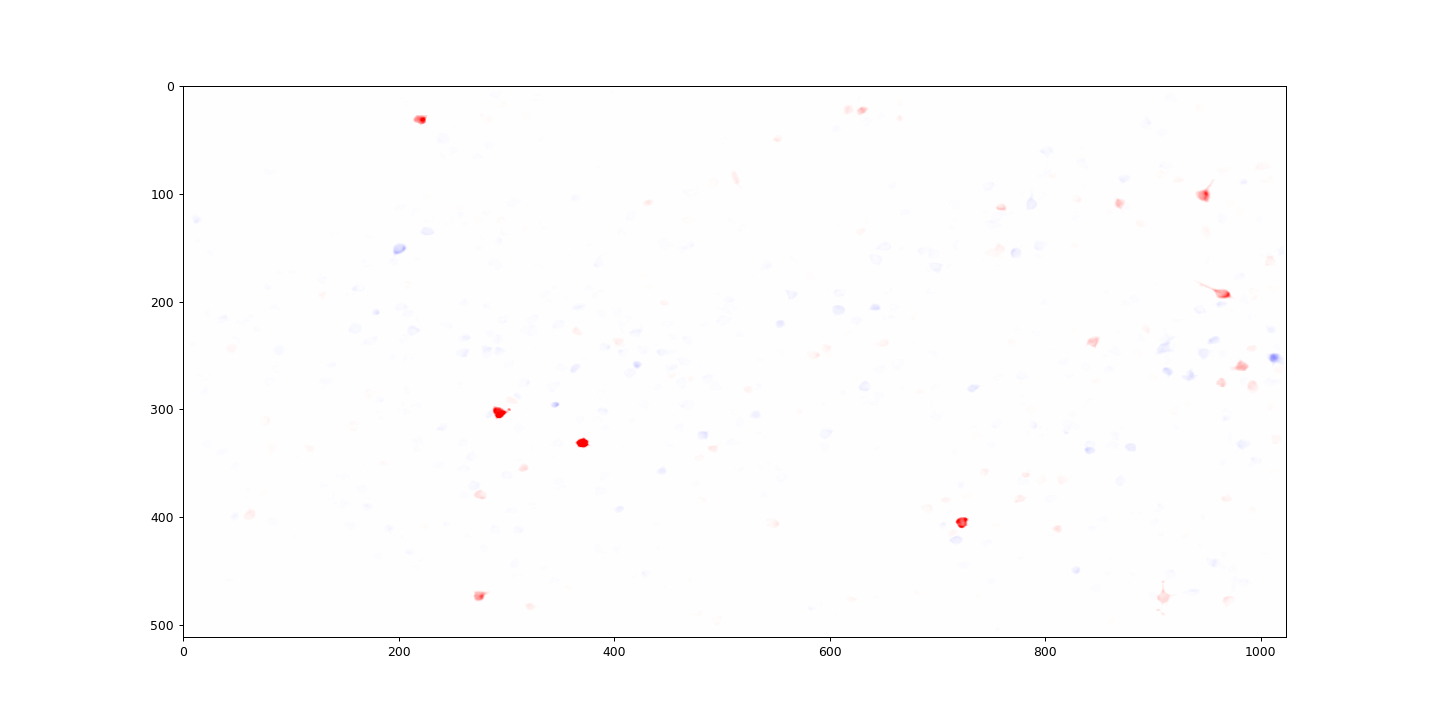

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [198]:
weights = factors_final.copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(weights.shape[0], frame_height, frame_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-1*sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

In [199]:
factors_final.shape

(6, 1072)

<IPython.core.display.Javascript object>


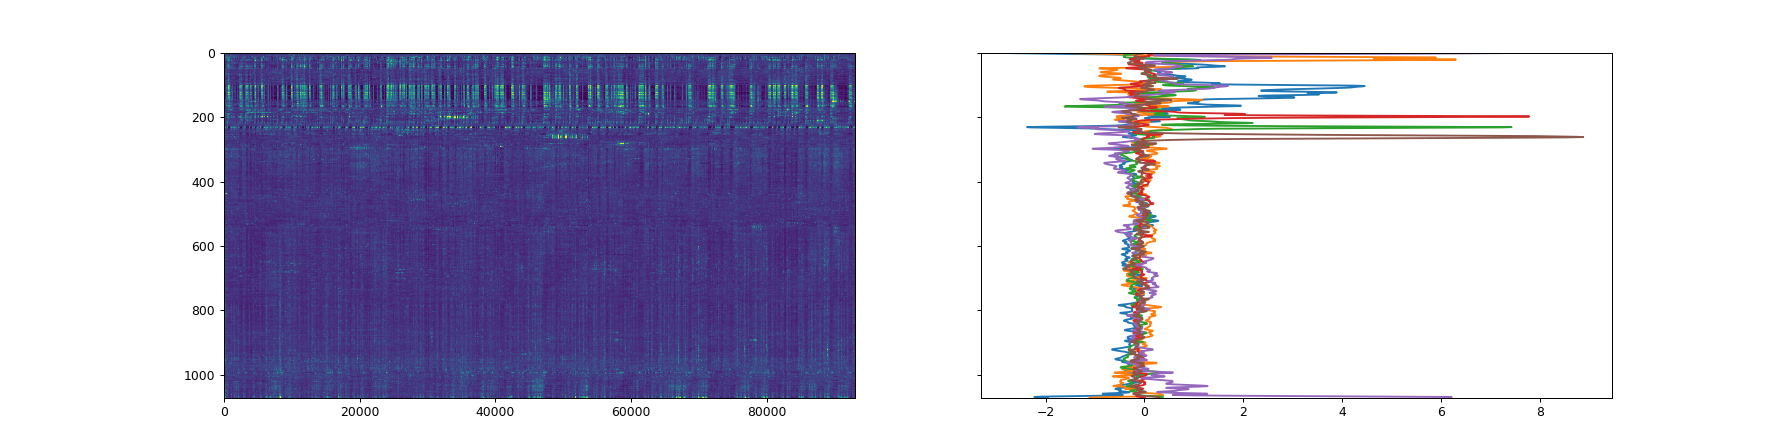

In [200]:
fig, axs = plt.subplots(1,2, figsize=(20,5), sharey=True)
axs[0].imshow(dFoF[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)
axs[1].plot(timeSeries.simple_smooth(factors_final[:,rmap.isort].T, sig=3, axis=0), np.arange(factors_final.shape[1]));

In [201]:
def make_evr_power_curve(factors, data, powers=[0, 1, 2, 3, 5, 10], device='cpu'):
    decoder = bmi_idap.decoder.Decoder_angle_magnitude(
        F=factors.T,
        device=device
    )
    
    Ds = [decoder(X=data, power=p)[0] for p in powers]
    
    evrs = [similarity.orthogonalize(data.T, d.T, device=device, method='OLS')[2] for d in tqdm(Ds)]
    
    return evrs

In [79]:
components_pca, scores_pca, singVals_pca, EVR_pca = decomposition.torch_pca(neural_data_toUse.T, mean_sub=True, device=device, return_numpy=True)

In [ ]:
vals_power = np.concatenate([[0], math_functions.bounded_logspace(0.1, 100, 30)])

# evrs = [make_evr_power_curve(f, neural_data_toUse, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_orth_ms_ordered_norm]]
evrs = [make_evr_power_curve(f, dFoF, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_final[:-1]]]

<IPython.core.display.Javascript object>


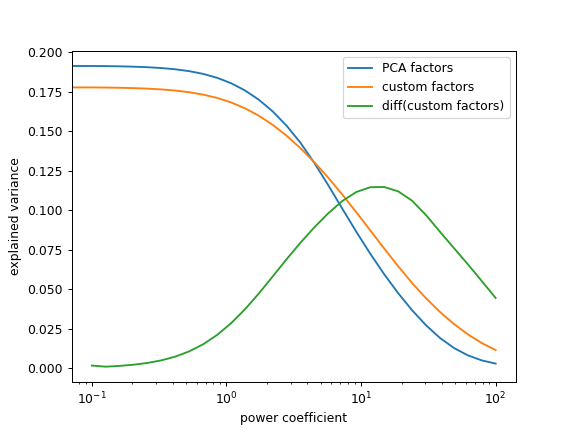

In [204]:
plt.figure()
plt.plot(vals_power, evrs[0])
plt.plot(vals_power, evrs[1])
plt.plot(vals_power[1:], np.diff(evrs[1])*-10)

plt.ylabel('explained variance')
plt.xlabel('power coefficient')
plt.xscale('log')
plt.legend(['PCA factors', 'custom factors', 'diff(custom factors)'])
# plt.ylim([0, 0.5])

In [205]:
results['manifold_alignment'] = {}

results['manifold_alignment']['components_pca'] = components_pca
results['manifold_alignment']['vals_power'] = vals_power
results['manifold_alignment']['evrs_pca'] = evrs[0]
results['manifold_alignment']['evrs_factors'] = evrs[1]

In [225]:
params['simulation'] = {}

params['simulation']['power'] = 1.5
params['simulation']['idx_factor'] = 0
params['simulation']['idx_avg'] = -1
params['simulation']['thresh_reward'] = 3.1
params['simulation']['thresh_quiescence_cursorDecoder'] = 0.2 * params['simulation']['thresh_reward']
params['simulation']['thresh_quiescence_cursorMag'] = 0.3
params['simulation']['thresh_quiescence_cursorMag'] = max([torch.quantile(M[params['simulation']['idx_factor']], q=params['simulation']['thresh_quiescence_cursorMag']).item(), 0])

params['simulation']['duration_quiescence_hold'] = 3
params['simulation']['duration_threshold_hold'] = 3
params['simulation']['win_smooth_cursor'] = 1

In [226]:
decoder = bmi_idap.decoder.Decoder_angle_magnitude(
    F=results['factors']['factors_final'].T,
    device=device,
    power=params['simulation']['power'],
)

D, CS, M = decoder(dFoF)

In [227]:
params['simulation']['ptile_quiescence_avgVec'] = 0.8
params['simulation']['thresh_quiescence_avgVec'] = torch.quantile(CS[-1], q=params['simulation']['ptile_quiescence_avgVec'])

In [228]:
num_rewards, sm = bmi_idap.decoder.simple_cursor_simulation(
    D.T, 
    CS.T, 
    M.T,
    idx_cursor=params['simulation']['idx_factor'], 
    thresh_reward=params['simulation']['thresh_reward'], 
    thresh_quiescence_cursorMag=params['simulation']['thresh_quiescence_cursorMag'], 
    thresh_quiescence_cursorDecoder=params['simulation']['thresh_quiescence_cursorDecoder'], 
    duration_quiescence_hold=params['simulation']['duration_quiescence_hold'],
    duration_threshold_hold=params['simulation']['duration_threshold_hold'],
    win_smooth_cursor=1,
)

100%|██████████████████████████████████| 93000/93000 [00:06<00:00, 14124.91it/s]


In [229]:
rewards_per_min = num_rewards / (D.shape[1] / (Fs*60*1))

print(f"Rewards per minute: {rewards_per_min :.3f}")

Rewards per minute: 1.374


<IPython.core.display.Javascript object>


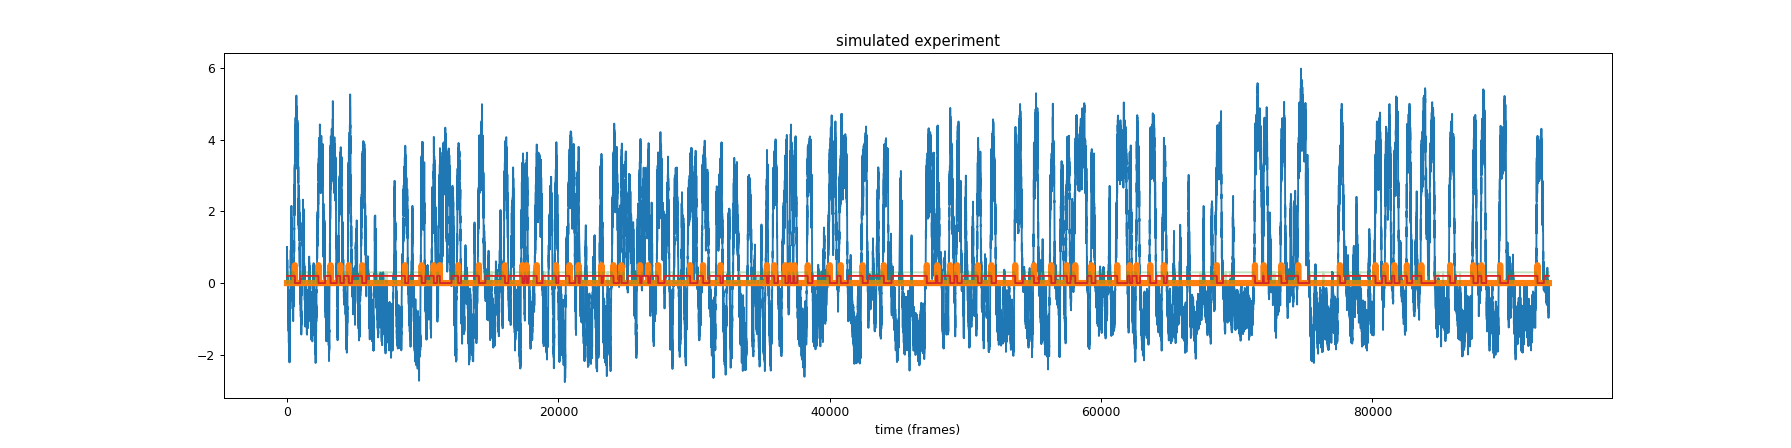

In [230]:
plt.figure(figsize=(20,5))
plt.plot(sm['cursor'])
plt.plot(sm['rewards']*0.5, linewidth=5)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.title('simulated experiment')
plt.xlabel('time (frames)');

In [231]:
results['simulation'] = {}

results['simulation']['idx_factor'] = params['simulation']['idx_factor']
results['simulation']['D'] = D
results['simulation']['CS'] = CS
results['simulation']['M'] = M
results['simulation']['num_rewards'] = num_rewards
results['simulation']['rewards_per_min'] = rewards_per_min
results['simulation']['sm'] = sm

<IPython.core.display.Javascript object>


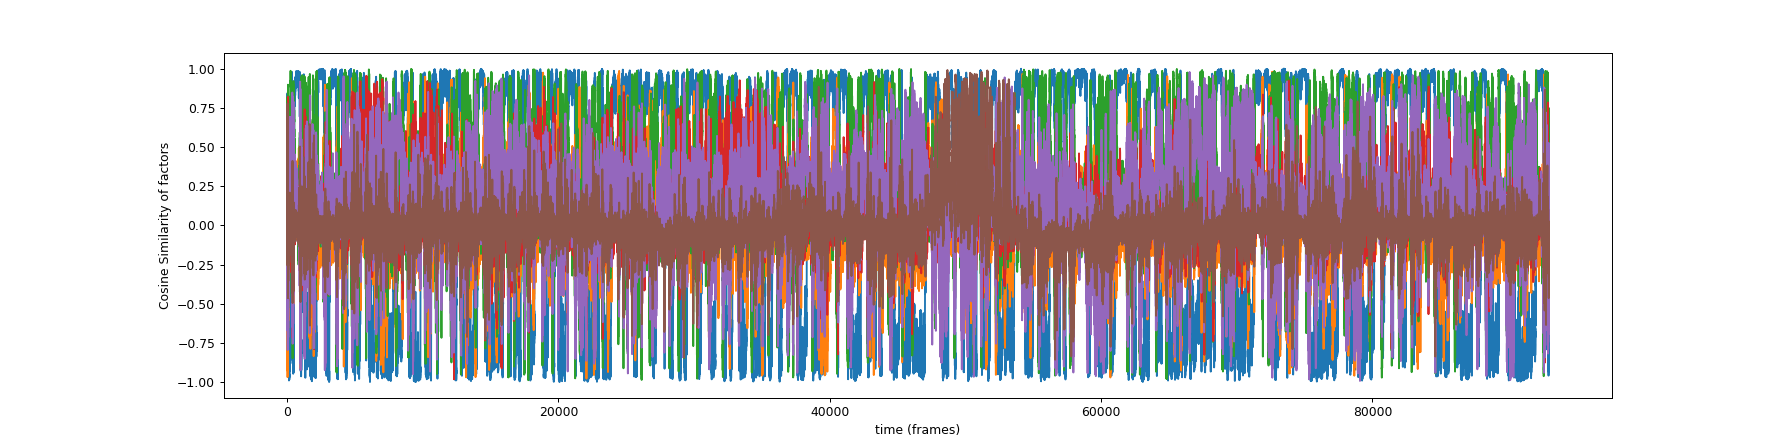

In [233]:
plt.figure(figsize=(20,5))
plt.plot(CS.T.cpu());
plt.xlabel('time (frames)')
plt.ylabel('Cosine Similarity of factors');

<IPython.core.display.Javascript object>


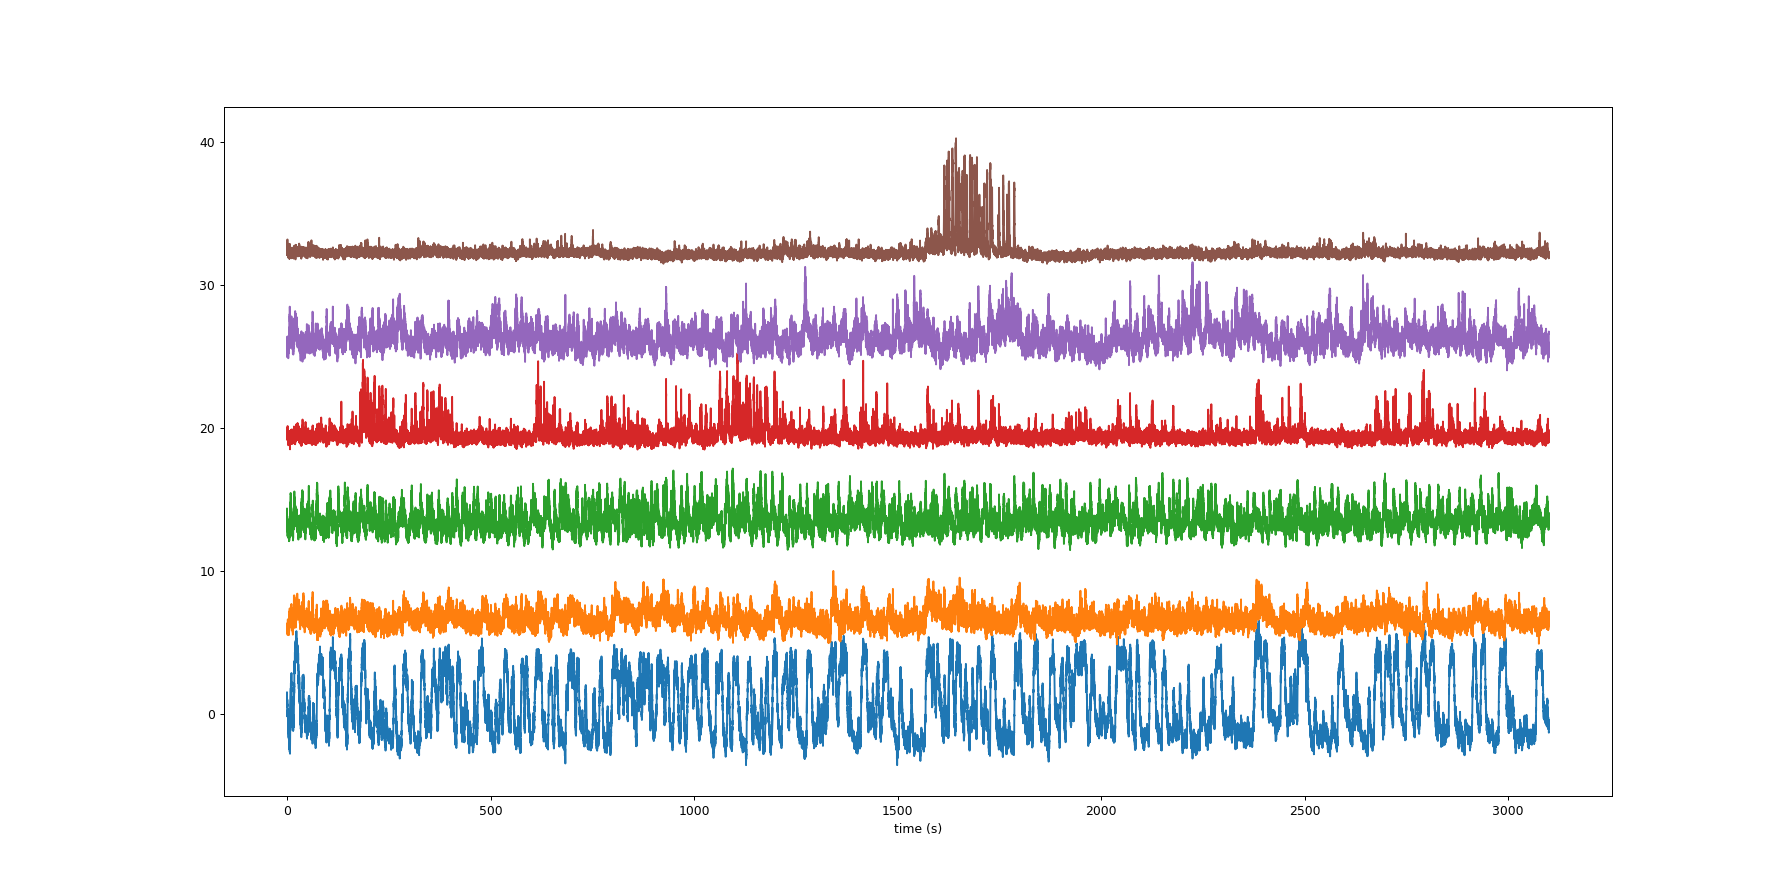

In [234]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(M.shape[1])/Fs, (M.cpu() + torch.arange(M.shape[0])[:,None]*M.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


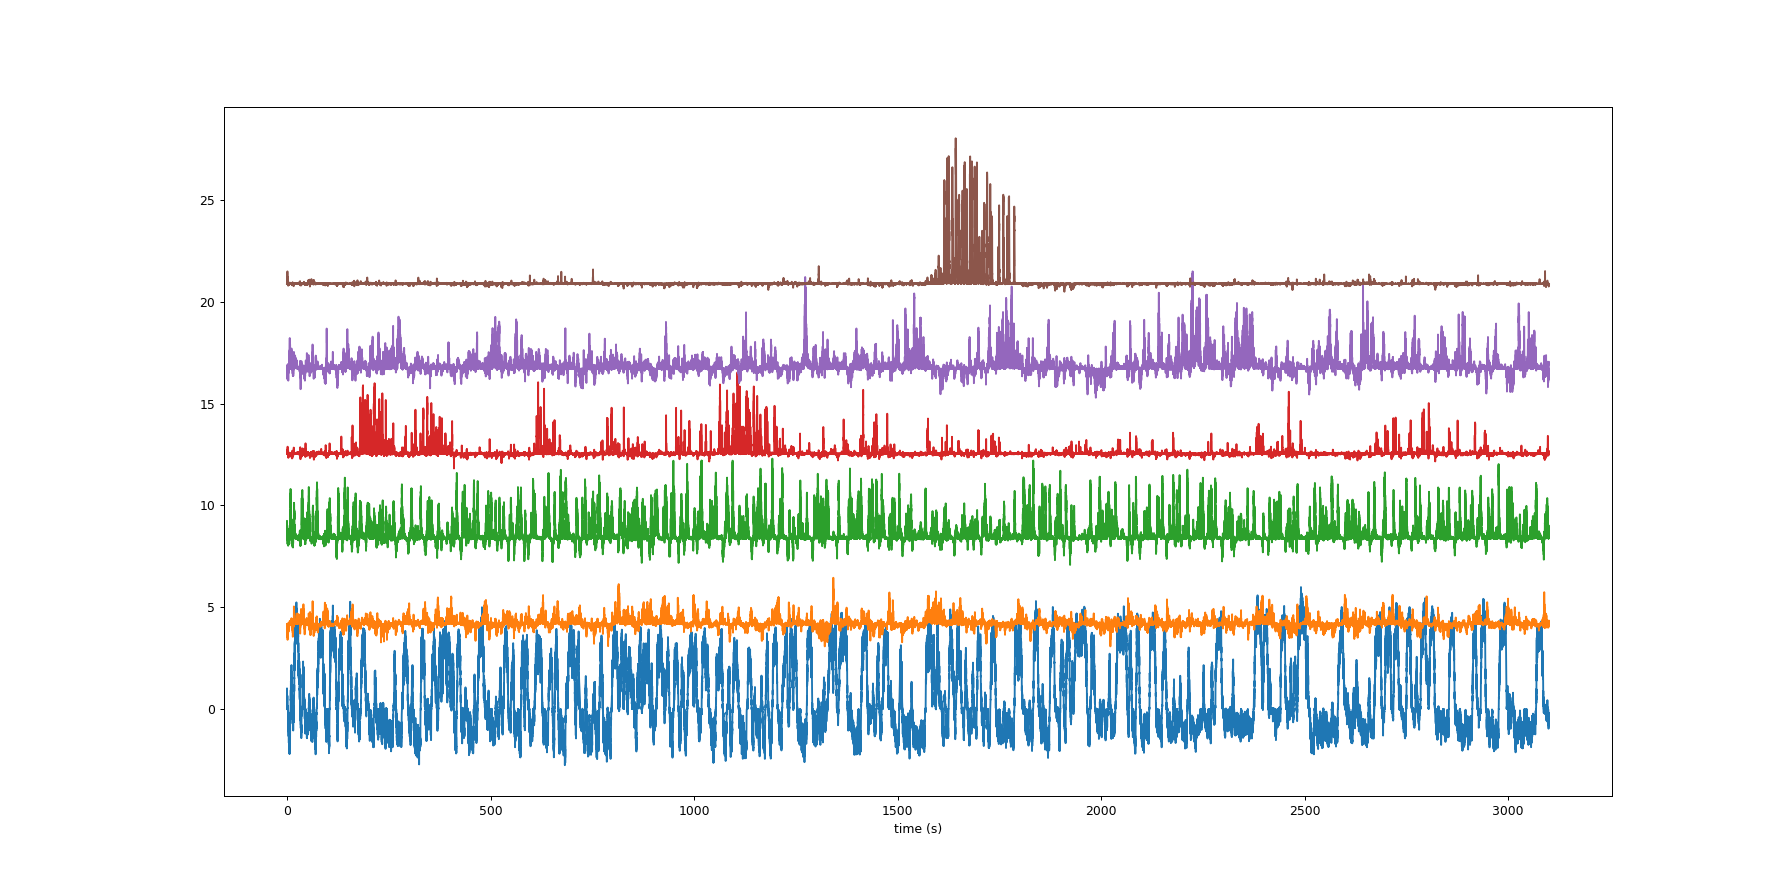

In [235]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(D.shape[1])/Fs, (D.cpu() + torch.arange(D.shape[0])[:,None]*D.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


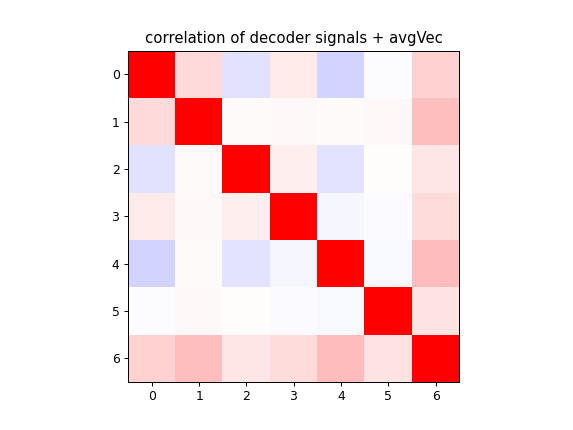

In [238]:
plt.figure()
plt.imshow(
    np.corrcoef(np.concatenate(
        (D.cpu(), dFoF_mean[None,:]), axis=0   
    )), vmin=-1, vmax=1, cmap='bwr'
);
plt.title('correlation of decoder signals + avgVec');

In [239]:
results['factors']['factors_final']

array([[ 5.79530617e+00,  5.12364208e+00,  2.43104969e+00, ...,
         1.94302913e-01, -8.07178473e-02, -6.51307637e-01],
       [-1.99463008e+00, -1.24706382e+00, -6.41861529e-01, ...,
        -8.18231037e-02,  9.93155896e-02,  1.41152357e-01],
       [ 2.10220798e-02,  2.76710739e-01,  1.41357198e+00, ...,
        -7.28606086e-02, -1.41188099e-01, -3.19266085e-03],
       [-1.05561222e-01,  8.24956658e-02, -3.25810132e-01, ...,
         8.61642013e-02, -2.41466582e-01, -4.44734940e-02],
       [ 1.95109321e+00,  1.06463274e+00, -3.61283393e-01, ...,
        -2.17697750e-01, -1.19845426e-01, -1.06502777e+00],
       [-2.44344954e-01, -4.01512116e-02, -3.07563675e-02, ...,
        -9.35913045e-02, -1.90675829e-01, -3.87791790e-01]])

In [240]:
directions = np.arange(params['rank']) * (360 / params['rank'])

In [241]:
x, y = np.cos(np.deg2rad(directions)), np.sin(np.deg2rad(directions))
xy = np.stack((x,y), axis=1)
np.random.shuffle(xy)

In [246]:
test1 = M.T.cpu().numpy() @ xy
test2 = D.T.cpu().numpy() @ xy

In [247]:
test3 = np.einsum('ij,ik -> ikj', M.cpu().numpy(), xy)

<IPython.core.display.Javascript object>


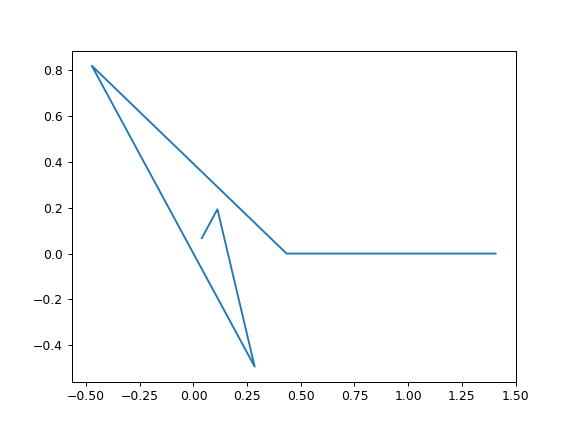

In [248]:
plt.figure()
plt.plot(test3[:,0,0], test3[:,1,0])

<IPython.core.display.Javascript object>


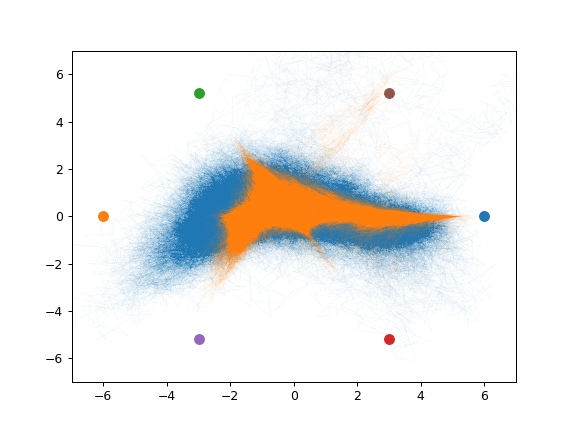

(-7.0, 7.0)

In [249]:
%matplotlib notebook

plt.figure()
[plt.scatter(xy[ii,0]*6, xy[ii,1]*6, s=60) for ii in range(len(x))]
plt.plot(test1[:,0], test1[:,1], linewidth=0.02)
plt.plot(test2[:,0], test2[:,1], linewidth=0.02)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

visualization of final traces and masks

# Save it all

In [250]:
weights_day0 = {
    "factors" : results['factors']['factors_final'],
    "iscell_custom": results['data']['iscell'],
    "spatialFootprints": results['data']['spatialFootprints'],
    "params": params,
}

scipy.io.savemat(str(Path(params['paths']['path_save_weights']).with_suffix('.mat')) , weights_day0)
np.save(str(Path(params['paths']['path_save_weights']).with_suffix('.npy')) , weights_day0)


file_helpers.pickle_save(
    obj={'results': results, 'params': params},
    path_save=str(Path(params['paths']['path_save_results']).with_suffix('.pkl')),
)